<div style='padding: 20px; text-align: justify'>
<center>

# Мэтчинг товаров.

</center>
</div>

## Описание проекта.

- __Задача.__
  - Разработка алгоритма, который для всех товаров из `validation.csv` найдет 5 похожих из `base.csv`.
- __Метрика.__
  - Необходимо максимизировать метрику `accuracy@5`, которая для каждого объекта вычисляется по формуле:
$$
accuracy@5 = 100 * \frac{\text{кол-во верно определённых похожих объектов из 5 возможных}} {5}
$$
- __Данные.__
  - Источник: https://disk.yandex.ru/d/BBEphK0EHSJ5Jw
  - `base.csv` : база данных всех товаров.
    - Насчитывает 72 признака и 2918139 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
  - `train.csv` : обучающая выборка, взятая из `base.csv`.
    - Насчитывает 73 признака и 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
    - Признаки включают столбец с размеченными экспертами идентификаторами похожих товаров из `base.csv`
  - `validation.csv` : база данных товаров, взятых из `base.csv`, для которых необходимо найти похожие.
    - Насчитывает 72 признака и 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.
  - `validation_answer.csv` : база данных, с разметкой похожих для товаров из `validation.csv`.
    - Насчитывает 100000 объектов.
    - Индекс состоит из уникальных идентификаторов товаров.Индекс состоит из уникальных идентификаторов товаров.

- __План работы__:
    - [Загрузка библиотек.](#Загрузка-библиотек.)
    - [Установка параметров проекта.](#Установка-параметров-проекта.)
    - [Ознакомление с данными, ИАД.](#Ознакомление-с-данными,-ИАД.)
    - [Предобработка данных.](#Предобработка-данных.)
    - [Кластеризация с поиском `K=5` похожих.](#Кластеризация-с-поиском-K=5-похожих.)
      - [Базовые модели.](#Базовые-модели.)
      - [Масштабирование и удаление признаков.](#Масштабирование-и-удаление-признаков.)
      - [Вычисление оптимального кол-ва кластеров.](#Вычисление-оптимального-кол-ва-кластеров.)
      - [`FAISS`. Тесты параметров.](#FAISS.-Тесты-параметров.)
      - [`ANNOY`. Тесты параметров.](#ANNOY.-Тесты-параметров.)
      - [Вложенный `KMeans` + `NearestNeighbors`.](#Вложенный-KMeans-+-NearestNeighbors.)
    - [Общий вывод.](#Общий-вывод.)

</div>

## Загрузка библиотек.

In [1]:
### os для обращения к среде разработки и requests
### для интернет запросов.
import os, requests
# urlencoed для кодирования ссылок.
from urllib.parse import urlencode
### zipfile для распаковки zip
import zipfile
### itertools для итераций комбинаций.
import itertools
### numpy для вычислений.
import numpy as np
### pandas для работы с датафреймами
import pandas as pd

### Визуализация.
# matplotlib для визуализации.
import matplotlib.pyplot as plt

# seaborn для визуализации.
import seaborn as sns

### Тесты для сравнения выборок.
from scipy.stats import kstest
from scipy.stats import zscore

### Методы и классы для работы с моделями.
# Разделение выборок.
from sklearn.model_selection import train_test_split
# robustscaler устойчивый к выбросам
from sklearn.preprocessing import (RobustScaler,
                                   StandardScaler,
                                   QuantileTransformer)
from sklearn.metrics import (silhouette_score,
                             davies_bouldin_score)

### Модули для контроля времени и хода исполнения ячеек.
## perf_counter для контроля времени.
from time import perf_counter
## tqdm для контроля выполнения ячеек;
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from tqdm.contrib.itertools import product
# Для подавления FutureWarning от Pandas.
from warnings import simplefilter

## Модели.
# Кластеризация.
from sklearn.cluster import KMeans, MiniBatchKMeans
# Дерево решений.
from sklearn.tree import DecisionTreeRegressor
# NeirestNeighbors.
from sklearn.neighbors import NearestNeighbors

# FAISS.
!pip install faiss-cpu -q
import faiss
# ANNOY.
!pip install annoy -q
from annoy import AnnoyIndex

### HTML для настройки отображения эл-тов.
from IPython.core.display import HTML

<div style='width: 700px; text-align: justify'>
    
## Установка параметров проекта.
- Укажем путь к загружаемым файлам в `BASE_PATH`.
- Установим другие параметры проекта.

In [2]:
# Укажем путь к датасетам и названия файлов.
if os.getenv("COLAB_RELEASE_TAG"):
    BASE_PATH = ('/content/drive/Othercomputers/'+
                 'My_Computer/JupiterNB/datasets/')
else:
    BASE_PATH = './datasets/'

BASE_NAME = ['matching_base.csv',
             'matching_train.csv',
             'matching_validation.csv',
             'matching_validation_answer.csv']

# Установим количество искомых похожих объектов по условию задачи.
K = 5

# Установим начальное значение генератора псевдослучайных чисел.
SEED = 42
np.random.seed(SEED)

# Установим стиль отображения заголовков таблиц.
styles = [
    dict(selector='caption',
         props=[('text-align', 'center'),
                ('font-size', '110%'),
                ('font-weight', 'bold'),
                ('white-space', 'pre-wrap')]),
    dict(selector="th",
         props=[('max-width', '250px')])
   7 ]

# Установим отображение всех столбцов при выводе датафрейма.
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Игнорируем FutureWarning от Pandas.
simplefilter(action='ignore', category=Warning)

# Установим диск для Google Colab.
if os.getenv("COLAB_RELEASE_TAG"):
    from google.colab import drive
    drive.mount('/content/drive/')

<div style=' padding: 20px'>

## Загрузка данных.

- Функция загрузки данных.

In [3]:
# Функция загрузки и записи в переменные любого количества датасетов
# по ссылкам или пути с проверкой адреса/пути.
def fetch_datasets(pths,
                   directory=None,
                   separator=',',
                   index_col=None,
                   dtype=None):
    '''
    Fetches and assigns datasets to variables through abs. path or the
    path passed as directory.
    Arguments:
    - pths: str, list. Full string path in quotes or list of links or
    list of file paths as list of strings.
    - directory: str. Working directory if needed.
    - separator: str, default=','. Separator as a string.
    - Example: ('/datasets/file.csv' or ['https://datasets/file.csv']
      or 'file.csv', '').
    '''
    # Переведём путь/имена файлов в список при необходимости.
    pths = [pths] if isinstance(pths, str) else pths

    print("\n\033[1m",
          'Начало загрузки и записи датасетов в переменные:',
          "\033[0m")

    for pth in tqdm(pths):
        # Запишем полный путь для вывода при указании директории.
        if directory:
            pth = os.path.join(directory, pth)

        # Запишем название и расширение файла.
        full_name = os.path.basename(pth)
        name, extension = os.path.splitext(full_name)

        # Проверим ссылку и запишем датасет в переменную.
        if 'http' in pth:
            # Воспользуемся try/except для непредвиденных ошибок.
            try:
                # Проверим корректность ссылки.
                if requests.get(pth).status_code == 200:
                    # Создадим переменную и запишем в неё датафрейм.
                    globals()[name.lower()] = pd.read_csv(
                        filepath_or_buffer=pth,
                        sep=separator,
                        index_col=index_col,
                        dtype=dtype
                        )
                    print(f'Файл {full_name} прочитан и записан в переменную ',
                          f'"{name.lower()}". \nПуть к файлу: \n{pth}')
                    print('~' * 60)
                else:
                    print(f'Ошибка чтения файла по пути: {pth}')
                    print('~' * 60)
            except:
                print(f'Ошибка чтения файла по пути: {pth}')

        # Проверим путь и запишем датасет в переменную.
        elif os.path.exists(pth):
            # Создадим переменную и запишем в неё датафрейм.
            globals()[name.lower()] = pd.read_csv(
                filepath_or_buffer=pth,
                sep=separator,
                index_col=index_col,
                dtype=dtype
                )
            print(f'Файл {full_name} прочитан и записан в переменную ',
                  f'"{name.lower()}". \nПуть к файлу: \n{pth}')
            print('~' * 60)

        else:
            print(f'Ошибка чтения файла по пути: {pth}.')
            print('~' * 60)

In [4]:
# Загрузка zip из интернет.
# def donwload_extract_to_mem(base_url, public_key, data_path):

#     final_url = base_url + urlencode(dict(public_key=public_key))
#     response = requests.get(final_url)
#     download_url = response.json()['href']

#     download_response = requests.get(download_url)
#     with open(data_path + 'data.zip', 'wb') as f:
#         f.write(download_response.content)

#     # Укажите путь к zip-архиву
#     zip_path = (data_path + 'data.zip')

#     # Распаковка zip-архива
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall()

# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'
# donwload_extract_to_memory(base_url, public_key, DATA_PATH)

In [5]:
# Определим словари типов данных для датафреймов `df_base`, `df_train` и
# `df_val`.
dict_base = {str(i) : 'float32' for i in range(72)}
dict_train = dict_base.copy()
dict_train['Target'] = 'str'
dict_val = {'id' : 'str'}
dict_val.update(dict_base)

# Прочитаем и запишем датасеты в переменные.
for df, idx_col, d_type in zip(BASE_NAME,
                               [0,0,0,0],
                               [dict_base, dict_train, dict_val, None]):
    fetch_datasets(pths=df,
                   directory=BASE_PATH,
                   index_col=idx_col,
                   dtype=d_type)


 Начало загрузки и записи датасетов в переменные: 


  0%|          | 0/1 [00:00<?, ?it/s]

Файл matching_base.csv прочитан и записан в переменную  "matching_base". 
Путь к файлу: 
./datasets/matching_base.csv
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Начало загрузки и записи датасетов в переменные: 


  0%|          | 0/1 [00:00<?, ?it/s]

Файл matching_train.csv прочитан и записан в переменную  "matching_train". 
Путь к файлу: 
./datasets/matching_train.csv
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Начало загрузки и записи датасетов в переменные: 


  0%|          | 0/1 [00:00<?, ?it/s]

Файл matching_validation.csv прочитан и записан в переменную  "matching_validation". 
Путь к файлу: 
./datasets/matching_validation.csv
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Начало загрузки и записи датасетов в переменные: 


  0%|          | 0/1 [00:00<?, ?it/s]

Файл matching_validation_answer.csv прочитан и записан в переменную  "matching_validation_answer". 
Путь к файлу: 
./datasets/matching_validation_answer.csv
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


- Переименуем переменные.

In [6]:
df_base = matching_base
df_train = matching_train
df_val = matching_validation
df_val_answer = matching_validation_answer

<div style='padding-right: 20px; text-align: justify'>

# Ознакомление с данными, ИАД.

<div style='width: 700px; text-align: justify'>

## Вспомогательные функции.
Введём вспомогательные функции:
- функцию поиска репрезентативного процента выборки;
- функцию вычисления процента выбросов;
- функцию вывода графиков ИАД.

<div style='width: 700px; text-align: justify'>

### Функция поиска репрезентативного процента выборки.

- Функция принимает датафрейм(ы) и список долей для перебора.
- Функция проводит двусторонние тесты Колмогорова-Смирнова для каждого признака в основной выборке и подвыборке.
- Функция выводит процент объектов для репрезентативной выборки, если распределения всех признаков идентичны.

In [7]:
# Функция поиска репрезентативного процента выборки.
def sample_kstest(x, y = None, frac=None):
    '''
    Calculates the representative sample percentage from presented list of
    fractions to test by conducting Kolmogorov-Smirnov test for two dataframes
    or tests two distributions for equality.
    Arguments:
    - x: dataframe | series | array.
    - y: series | array.
    - frac: list | array.
    '''

    if (isinstance(x, pd.DataFrame) and \
        not y and \
        isinstance(frac, (list, np.ndarray))):
        fracs = frac
        np.random.seed(42)

        for frac in fracs:
            i = 0
            y = x.sample(frac=frac, random_state=SEED)
            for col in x.columns:
                _, p_value = kstest(x[col], y[col])
                if p_value < .05:
                    break
                else:
                    i += 1
                if i == len(x.columns):
                    print('Распределения признаков в выборках одинаковы при'+
                    f' выборке {frac:.0%} объектов.')
                    return
        print('Найти репрезентативный процент выборки не удалось.')
    else:
        _, p_value = kstest(x, y)
        if p_value < .05:
            print(f'Распределение признаков различны.')
        else:
            print(f'Распределение признаков одинаковы.')

<div style='width: 700px; text-align: justify'>

### Функция вычисления процента выбросов.
- Функция примет
  - признак;
  - метку вывода пограничных значений;
  - коэффициент для расчёта пограничных значений<br>
  (по умолчанию коэффициент = 1.5, что соответствует "усам" диаграммы размаха и 2.7$\sigma$).
- Функция вычислит и выведет процент значений вне границ, и, при необходимости, пограничные значения.

In [8]:
# Введём функцию расчёта и вывода процентов выбросов для отобранных
# признаков.
def get_outliers_ratio(col: pd.Series, whiskers=False, iqr_coeff=1.5):
    '''
    Calculates boxplot whiskers and outlier percentage. Optionally returns
    whiskers.
    Arguments:
    - data: pd.DataFrame() | pd.Series(). Either DataFrame or Series variable.
    - whiskers: bool. whether to return whiskers (True) or not.
    - coeff: float. Default - 1.5 for 2.7 sigma. Can be changed to 1.7 for
      3 sigma.
    '''
    # Вычислим интерквартильный размах.
    distr_iqr = col.quantile(.75) - col.quantile(.25)
    # Вычислим границы.
    whisker_upp = col.quantile(.75) + iqr_coeff * distr_iqr
    whisker_low = col.quantile(.25) - iqr_coeff * distr_iqr
    # Если усы границы экстремумы, приравняем их.
    if whisker_upp >= col.max():
        whisker_upp = col.max()
    if whisker_low <= col.min():
        whisker_low = col.min()
    else:
        pass
    # Вычислим процент выбросов.
    outliers_ratio = (
        (col[col > whisker_upp].count() +
         col[col < whisker_low].count()) /
        len(col)
        )
    # Выведем границы и процент выбросов если необходимо.
    if whiskers:
        return whisker_low, whisker_upp, outliers_ratio
    # Выведем только процент выбросов.
    else:
        return outliers_ratio

<div style='width: 700px; text-align: justify'>

### Функция вывода графиков ИАД.
- Функция примет
  - датафрейм;
  - опционально:
    - название датайрейма;
    - процент подвыборки;
    - метку вывода процентов выбросов;
    - коэффициент для расчёта выбросов;
- Функция выведет гистограммы и диаграммы размаха для всех признаков датафрейма.

In [9]:
# Функция вывода графиков ИАД.
def get_eda_plots(df : pd.DataFrame, name = None,
                  sample_frac = None, seed = SEED,
                  outliers = True, iqr_coeff = 1.5):
    '''
    Plots histograms and boxplot diagrams for all features of a
    dataframe with sampling if required.
    Arguments:
    - df: pd.DataFrame;
    - name: str. Dataframe name;
    - sample: Bool. Whether sampling is required;
    - sample_frac: float. sampling fraction;
    - seed: random state seed for sampling;
    - outliers: Bool. Whether to show outlier percentage.
    - iqr_coeff: float. Coefficient for whiskers calculation.
      Mainly to choose from
      - 1.5 for 2.7 sigma;
      - 1.7 for 3 sigma.
    '''

    # Проверим необходимость сэмплирования.
    if sample_frac:
        df_to_plot = df.sample(frac=sample_frac, random_state=seed)
        sample_t = f' {sample_frac:.0%} выборки'
    else:
        df_to_plot = df
        sample_t = ''
    # Проверим указание названия датафрейма.
    name = f' {name}' if name else ''

    # Определим размер фигуры гистограмм.
    length = df_to_plot.shape[1]
    if length / 9 > 1:
        height = df_to_plot.shape[1] // 9 * 2.5
    else:
        height = 8

    # Выведем гистограммы.
    axs = df_to_plot.hist(figsize=(20, height), bins=50)
    if outliers:
        for ax, col in zip(axs.flatten(), df_to_plot.columns):
            outlier_perc = get_outliers_ratio(df[col], iqr_coeff=iqr_coeff)
            ax.set_title(f'Признак "{col}".\nВыбросов: '+
                         f'{outlier_perc:.1%}')
    plt.suptitle('Гистограммы' + sample_t + name + '.', y=.99, fontsize=16)
    plt.tight_layout()
    plt.show();

    # Выведем диаграммы размаха.
    df_to_plot.plot(kind='box', grid=True, figsize=[20, 8])
    plt.title('Диаграммы размаха'  + sample_t + name + '.', fontsize=16)
    plt.tight_layout()
    plt.show();

## Вывод информации о данных и графиков.

### Вывод общей информации о данных.

In [10]:
for df, name in zip(
    [df_base, df_train, df_val, df_val_answer],
    ['Общая выборка "df_base".',
     'Обучающая выборка "df_train"',
     'Валидационная выборка "df_val".',
     'Ответы валид. выборки "df_val_answer".']
    ):
    display(df.head().style.set_caption(name).set_table_styles(styles))
    print('\n')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,-124.061508,-32.458237,-57.420559,36.207405,182.716766,-28.071688,-5.209374,-1.732183,-91.091858,-79.466667,-103.939087,1507.231323,-32.591667,51.414360,-51.905361,813.770081,-41.556538,8.419807,-129.976639,148.765030,-10.069234,-143.005035,79.848694,-537.183716,2.773180,111.518677,4.257666,-153.340576,-123.626083,-39.707664,-12.768708,-4.170106,-152.967133,75.911522,-57.470089,17.266476,-98.871155,-138.067535,91.000381,-170.701996,-50.020390,59.794296,78.106377,-89.375725,89.412102,79.812180,-129.513611,-44.659496,-80.442207,5.149714,-64.518951,-138.777634,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,-141.304352,-126.768898,-68.853531,8.314717,143.081741,8.778257,15.157185,48.246361,-244.954865,-80.279419,-81.788040,429.880035,-5.937690,70.142654,66.576843,813.770081,3.214371,17.164303,-39.418385,148.155884,-7.579590,-174.369949,101.224632,-303.939240,16.914631,53.394676,33.451824,-148.552628,-110.340172,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948471,62.484821,-166.473358,-189.010422,-56.731556,-30.027319,59.171059,-56.711540,63.542606,-121.319168,97.426056,74.832840,-138.777054,58.887608,-71.595337,-251.952362,11.392853,-148.571655,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,-140.822449,-22.486748,-51.666988,2.521726,140.585449,-22.039230,-7.128633,-5.184787,-111.712120,-79.029266,-82.452576,1507.231323,-0.421011,84.108009,63.344509,813.770081,-105.211052,18.844700,-94.789474,151.387711,-21.483440,-144.845367,48.502934,-780.449158,64.767311,79.781555,-13.390142,-150.061661,-118.758553,-40.896286,-15.222620,-1.860338,-93.820656,98.749069,-46.745781,65.927475,-10.286392,-125.321373,21.048609,-22.637775,68.915985,-54.902260,66.335472,-142.927917,83.030983,69.979630,-123.733887,65.320877,-114.037178,-529.396973,-101.581375,-134.658218,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,-108.470444,-104.537781,-82.388489,-79.986740,113.596313,-38.995880,-4.787360,8.327808,-124.855759,-79.109016,-107.943275,1479.170532,-125.271614,24.656485,-16.921055,813.770081,-182.680267,14.715704,-62.932701,151.201981,10.613454,-134.934341,58.777729,-529.295044,43.665924,92.806305,-38.936657,-145.045303,-124.295769,-36.876732,-17.742870,10.536242,-124.584152,121.914146,-17.321358,105.217239,-94.379646,-63.769272,29.217487,-26.423973,5.869829,64.061546,63.513279,-112.258102,80.926590,72.636101,-137.314316,7.912551,-62.188919,-540.321045,-89.588715,-149.326691,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,-110.342453,-38.982059,-50.228867,-26.690920,135.272903,-7.510103,8.924209,111.576950,-130.833191,-79.315849,-57.843952,1262.919678,19.225910,59.811813,76.159668,312.698914,-76.726974,21.299923,-24.069107,167.385529,-44.059471,-148.131851,98.042610,-657.524414,96.363167,71.061523,-36.563557,-135.372437,-123.708977,-44.739437,-10.855220,8.354800,-168.328857,215.928070,-32.975979,66.864883,30.838631,-211.540375,57.695343,-67.822632,-29.38913

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,-88.082687,-52.695541,-27.692442,4.872923,198.348007,-30.075249,-3.803569,-135.810608,-161.841370,-78.512177,-94.428940,898.436951,-70.140518,78.420357,108.032776,813.770081,-74.790878,12.610422,-183.821838,149.715836,-27.042316,-133.212173,106.420746,-303.939240,48.730789,58.185707,24.250950,-151.224106,-104.282265,-34.492809,-12.587054,2.622891,-120.969917,149.991638,-31.948471,82.314430,-115.830467,-243.309387,6.622036,-132.197662,68.712563,-38.806824,62.937435,-132.654449,89.189026,87.039780,-121.279877,-6.986934,-206.513824,29.485588,-77.029587,-132.386169,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,-177.605804,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267029,-78.659431,-92.761490,353.157745,-34.744545,82.487106,-28.450592,813.770081,-137.529633,26.595627,-136.783447,153.357910,48.810093,-115.922150,87.464218,-222.286362,25.124149,91.887138,-30.636869,-136.593140,-140.500122,-43.449757,-7.226884,8.265747,-117.915466,149.150894,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061081,-7.139753,75.862396,-112.045113,82.857727,54.067215,-134.005386,-26.142574,-214.632111,-457.848450,21.459618,-137.411362,-40.812233,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,-86.346558,-35.666546,16.395317,-80.802849,137.908646,-23.532761,-47.256584,-16.650242,-194.505676,-78.372925,-69.324478,1507.231323,-52.500969,-34.165775,52.958652,813.770081,-18.021725,20.951107,-50.321781,158.760620,0.178065,-183.069672,99.053574,-1018.469543,-51.801121,97.766769,-10.865850,-144.423157,-133.819489,-78.902298,-17.200352,4.467452,-63.970737,154.639526,-30.211615,48.527401,-122.406639,-112.713623,53.461838,-31.117260,107.841507,16.482935,77.934479,-95.618729,91.460075,63.119511,-126.939247,8.066628,-195.677673,-163.119995,-72.830002,-139.223068,-52.031662,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255409,-775.150146,79.186523,124.003098,242.650650,-146.517075,-159.469849,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.906830,-78.789322,-78.737091,1507.231323,19.957405,34.834290,-8.820732,813.770081,-125.606796,17.584084,-58.452904,141.281799,-54.959309,-136.988541,63.880493,-1018.469543,89.228928,65.919960,-24.078644,-152.334106,-91.199379,-28.225389,-4.767386,0.158236,-129.128662,122.958366,-30.800995,123.623398,-37.540867,-72.139801,71.240990,-168.115585,118.236450,-18.065195,37.255718,-137.691040,87.500771,62.437290,-131.260635,35.692661,-86.038834,-379.339081,-153.465775,-131.198288,-61.567047,44.515266,-145.416748,93.990982,64.131348,106.061920,83.178757,118.277725,-1074.464844,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052536,57.127068,-16.239529,-321.317963,45.984676,125.941284,103.392670,-107.153023,-8.800034,-50.977798,29.457338,143.389313,5.614824,-45.274761,9.643625,-77.554626,-79.066612,-77.926460,1507.231323,16.612400,116.284286,33.754898,813.770081,-105.765335,6.523008,-19.812988,157.693924,-20.604088,-146.591278,78.849571,-780.449158,87.560768,73.036659,16.891029,-144.657898,-116.122147,-19.353254,-7.709266,-5.394988,-140.252121,193.184967,-53.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,-131.892807,-140.968567,-57.987164,-22.868887,150.895523,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579521,263.363129,56.266876,66.924713,21.609911,813.770081,-32.782940,20.794031,-79.779076,156.307083,-42.831329,-71.723335,83.283661,-304.174377,1.609402,55.834587,-29.474255,-139.162766,-126.038353,-62.643829,-5.012346,11.984921,-43.084946,190.123993,-24.996635,76.153900,-245.261566,-143.656479,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697319,60.475632,-127.486870,-39.484753,-124.384575,-307.949768,45.506813,-144.190948,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,-153.717255,-63.951328,-52.369495,-33.390945,148.619507,-22.483829,15.164185,-56.202000,-153.614380,-79.831825,-101.055481,1203.537109,81.597130,101.018654,56.783424,92.209625,-126.860336,10.382887,-38.523361,165.383911,-77.840485,-169.538681,103.483238,-915.735718,16.109938,14.669937,-38.707085,-149.538376,-138.792923,-36.076176,-2.781422,2.283144,-142.477890,189.953949,-18.408230,90.517052,-95.530998,-259.636047,52.437836,-30.004599,14.502060,-1.071201,66.842667,-161.279892,94.794174,50.419983,-125.075256,-25.169033,-176.176880,-655.836914,-99.238373,-141.535217,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,-220.309540,-31.378445,-8.788761,2.285323,133.266113,-41.309078,14.305538,-18.231812,-205.533707,-78.160309,-96.607674,1507.231323,-5.964200,34.937443,-56.086887,813.770081,-13.200474,18.966661,-35.110191,151.368500,-17.490252,-145.884293,15.533379,-655.395508,39.412827,62.554955,9.924992,-143.934616,-123.107796,-37.032475,-13.501337,12.913328,-116.038017,176.276154,-45.909943,103.491364,-90.656990,-162.615707,117.128235,13.079479,69.826889,-6.874451,63.707214,-123.851067,91.610817,59.760067,-129.566177,-12.822194,-154.197647,-407.199066,5.522629,-126.812973,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,58.576405,-19.046659,115.042404,75.206734,-114.271957,-71.406456,-65.349319,24.377069,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690697,-139.227448,325.547119,3.632292,74.929504,-4.802103,813.770081,-52.982597,15.644382,-54.087467,151.309143,21.088570,-134.507889,65.118958,-529.295044,131.565521,67.642700,-22.884491,-145.906525,-86.917328,-11.863579,-22.188885,0.463720,-212.533752,170.522583,-48.092533,99.712555,-194.692413,-141.523178,60.217049,73.386383,118.567856,58.900810,55.569031,-181.091660,83.340485,66.083237,-114.048866,-57.156872,-56.335075,-318.680054,-15.984783,-128.101334,-77.236107,44.100494,-132.530121,-106.318985,70.883957,23.577892,133.183960,143.252945,-799.363647,-89.392670
100004-query,-79.532921,-0.364173,-16.027431,-170.884949,165.453918,-28.291668,33.931934,34.411217,128.903976,102.086914,-76.214172,-26.393860,34.423641,50.938889,157.683182,-23.786497,-33.175415,-0.592607,-193.318542,-79.651031,-91.889786,1358.481079,44.027733,121.527206,46.182999,433.623108,-82.233200,21.068508,-32.940117,149.268951,0.404718,-97.674530,81.719994,-825.644775,9.397169,49.359341,17.725466,-160.168152,-129.367950,-55.532898,-2.597821,-0.226103,-41.369141,92.090195,-58.626858,73.655441,-10.257370,-175.656784,

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [11]:
for df, name in zip(
    [df_base, df_train, df_val, df_val_answer],
    ['Общая выборка "df_base".', 'Обучающая выборка "df_train"',
     'Валидационная выборка "df_val".',
     'Ответы валидационной выборки "df_val_answer".']
    ):
    print('\033[1m' + name + '\033[0m', '\n' + '-' * 25)
    print('\033[1mРазмер датафрейма:\033[0m')
    display(df.shape)
    print('\n\033[1mТип данных:\033[0m')
    display(df.info())
    print('\n\033[1mОбщее кол-во пропусков в датафрейме:\033[0m')
    display(df.isna().sum().sum())
    print('\n\033[1mОбщее кол-во дубликатов в датафрейме:\033[0m')
    display(df.duplicated().sum().sum())
    print('~' * 70, '\n\n')

Общая выборка "df_base". 
-------------------------
Размер датафрейма:


(2918139, 72)


Тип данных:
<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      float32
 36  36      float32
 37  37      float32
 38  38      float32
 39  39 

None


Общее кол-во пропусков в датафрейме:


0


Общее кол-во дубликатов в датафрейме:


0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 


Обучающая выборка "df_train" 
-------------------------
Размер датафрейма:


(100000, 73)


Тип данных:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  floa

None


Общее кол-во пропусков в датафрейме:


0


Общее кол-во дубликатов в датафрейме:


0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 


Валидационная выборка "df_val". 
-------------------------
Размер датафрейма:


(100000, 72)


Тип данных:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null

None


Общее кол-во пропусков в датафрейме:


0


Общее кол-во дубликатов в датафрейме:


0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 


Ответы валидационной выборки "df_val_answer". 
-------------------------
Размер датафрейма:


(100000, 1)


Тип данных:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


None


Общее кол-во пропусков в датафрейме:


0


Общее кол-во дубликатов в датафрейме:


8498

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 




<div style='width: 700px; text-align: justify'>

### Вывод графиков ИАД.
- Т.к. датафреймы `df_train` и `df_val` являются подвыборками `df_base`, ограничимся выводом графиков для этого датафрейма.
- Т.к. `df_base` содержит большое кол-во объектов, для построения гистограмм и диаграмм размаха вызовем соответствующую функцию и найдём процент выборки, при котором подвыборка будет репрезентативна.<br>

> __Примечание:__ Для экономии времени исполнения вызова функции, список долей сокращён на неуспешные `np.linspace(.01, .09, 5)`.

In [12]:
sample_kstest(x=df_base, frac=np.linspace(.1, .9, 8))

Распределения признаков в выборках одинаковы при выборке 10% объектов.


- Вызовем функцию и выведем графики для репрезентативной подвыборки.

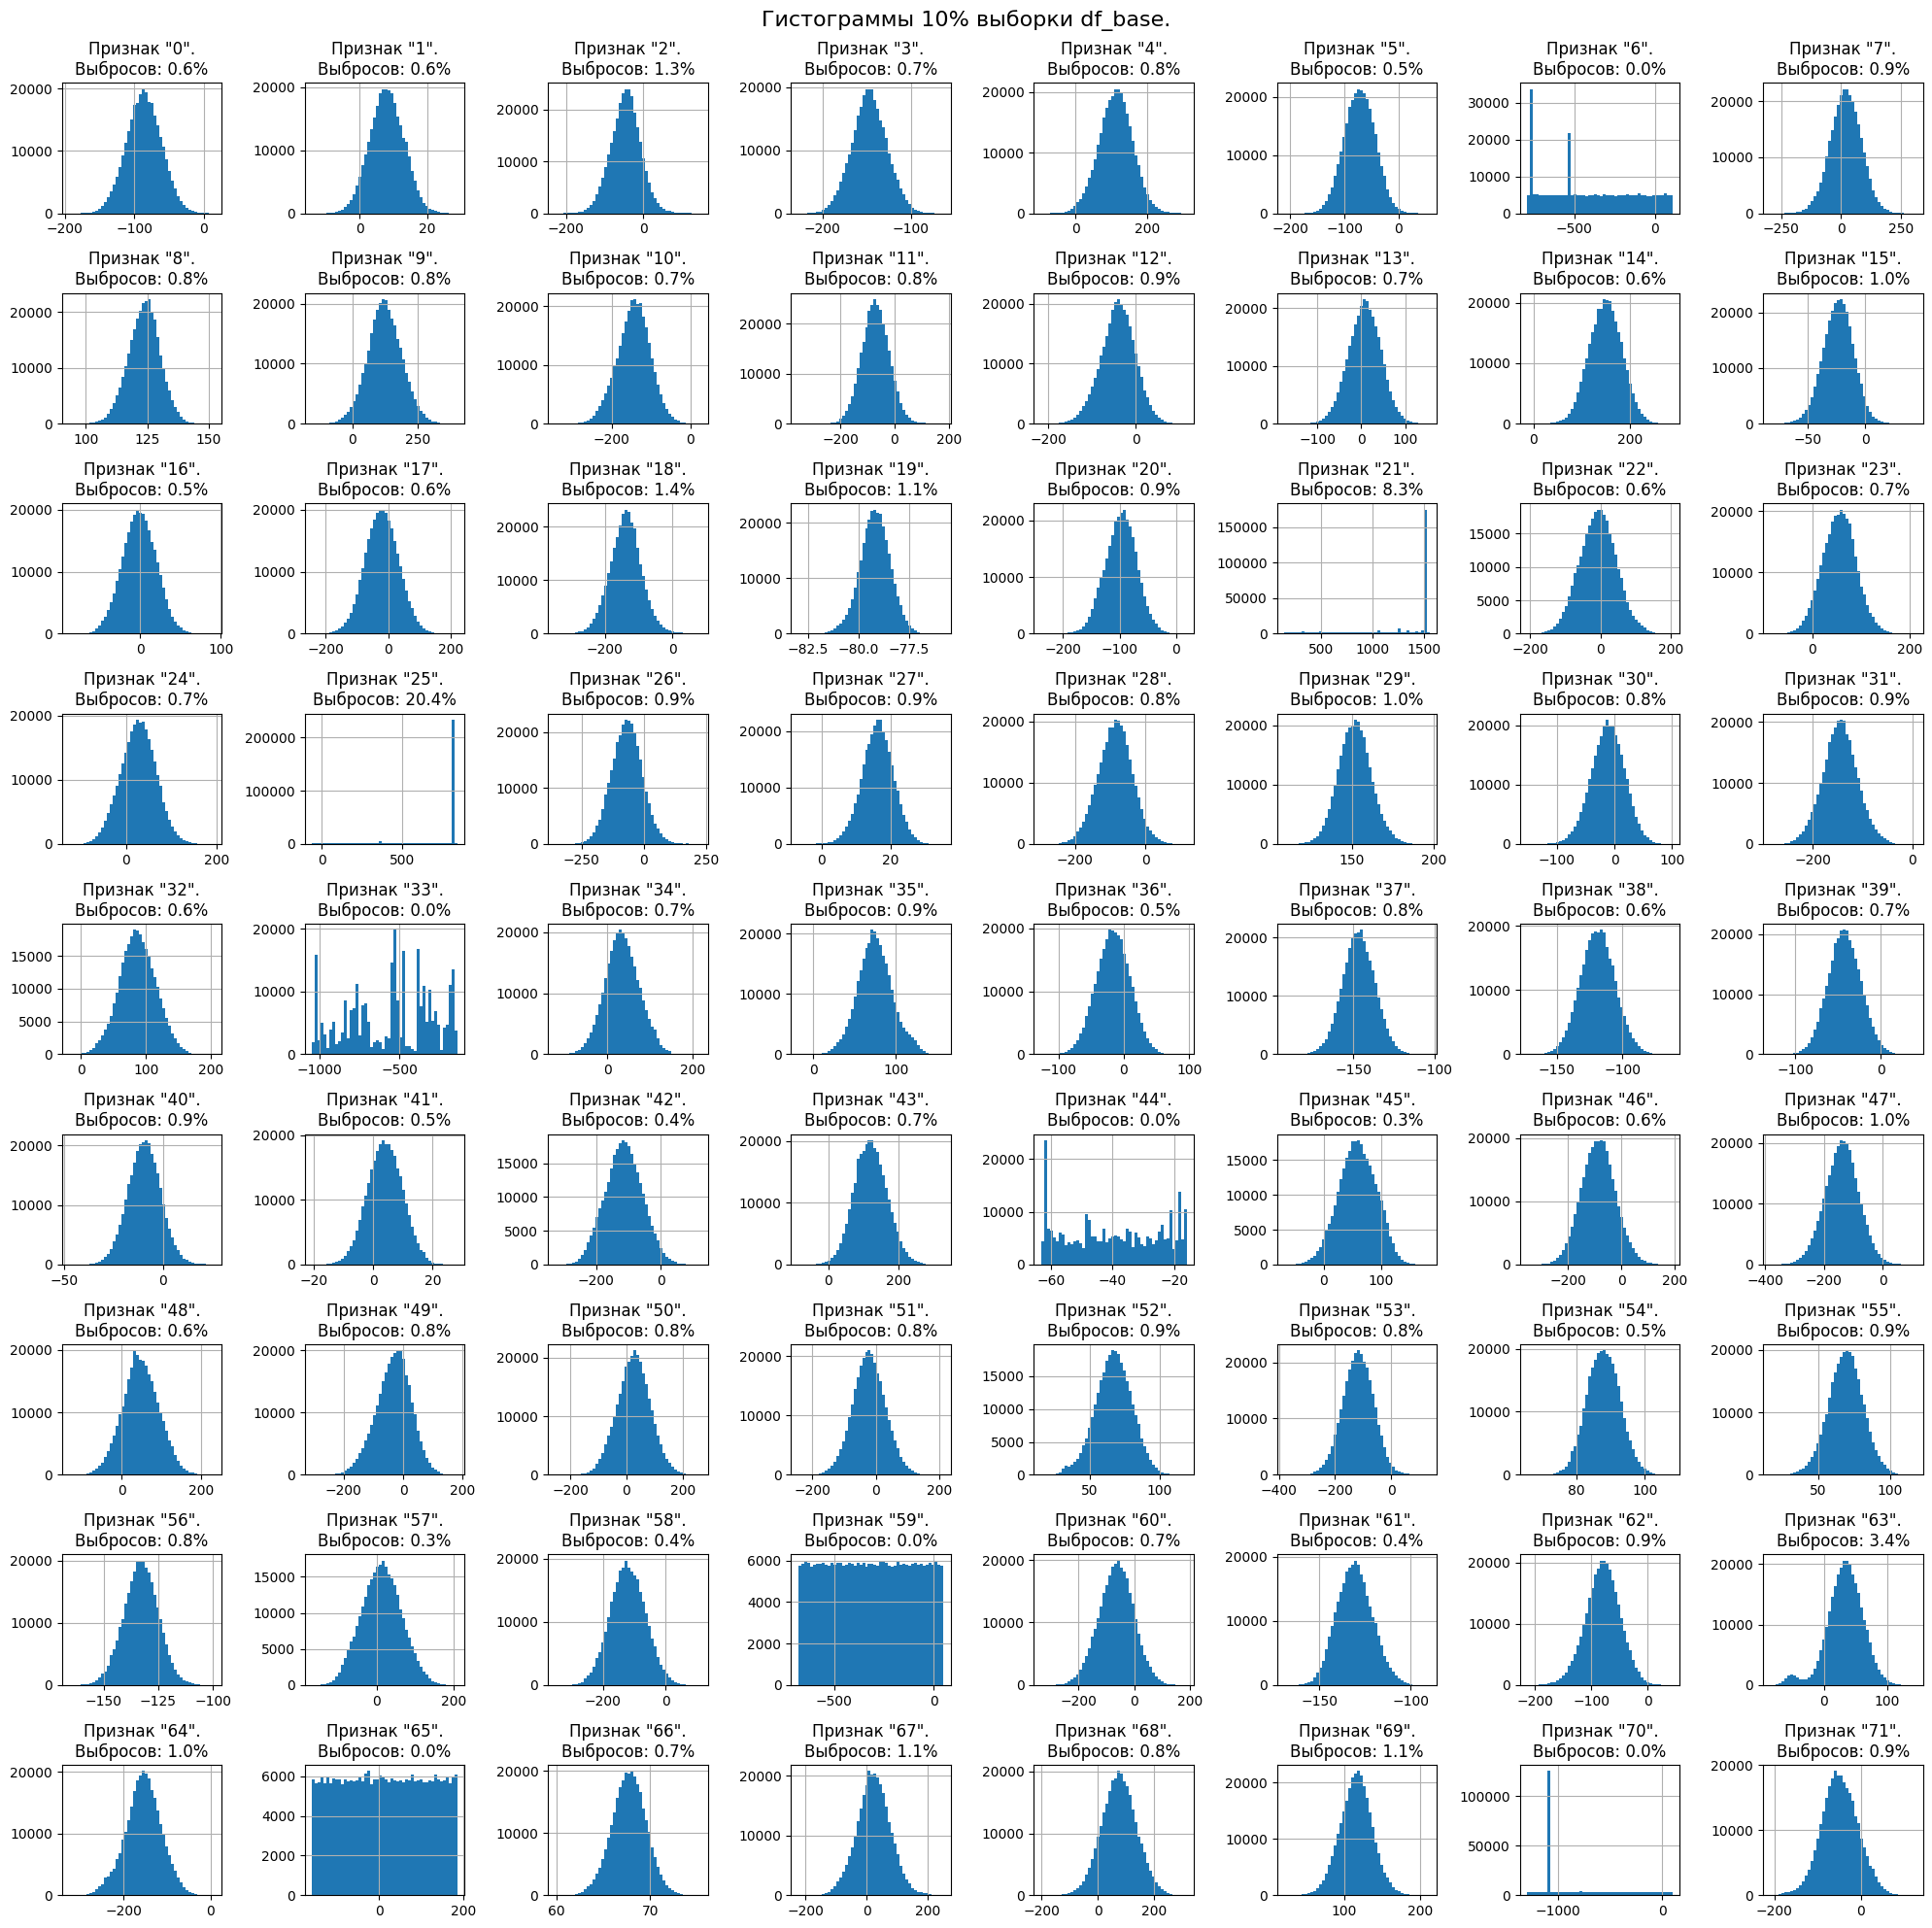

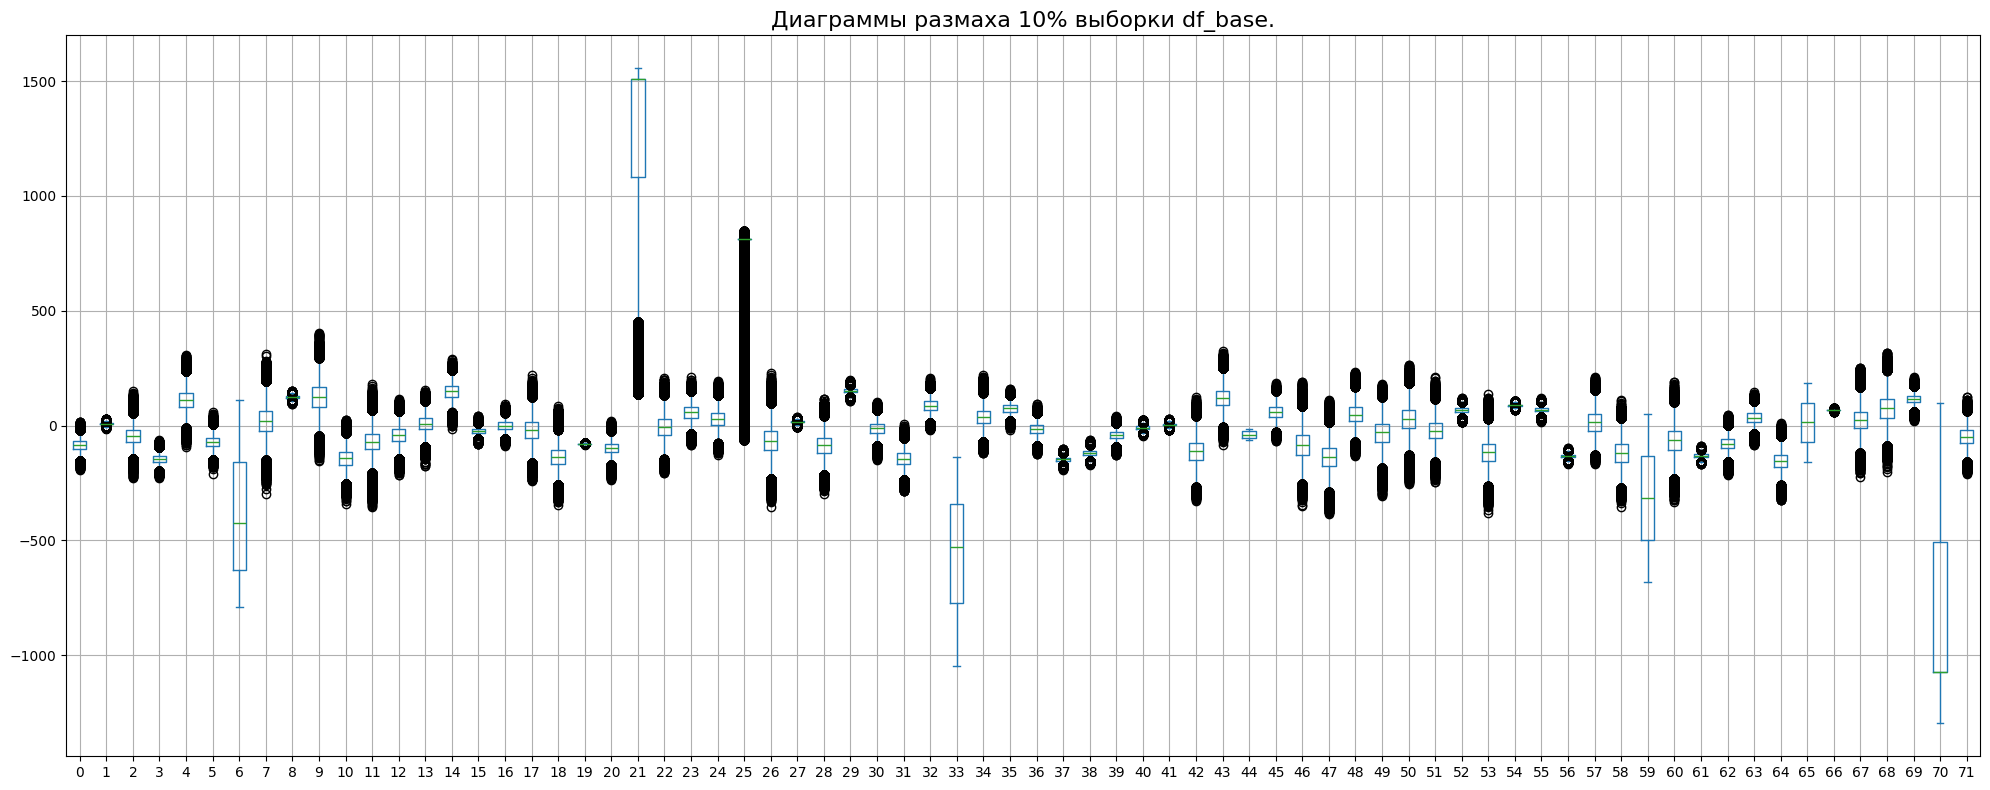

In [13]:
get_eda_plots(df=df_base, name='df_base', sample_frac=.1)

### Вывод доп. информации.

In [14]:
df_base.sample(frac=.1, random_state=SEED).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000,291814.000000
mean,-86.228691,8.066578,-44.621460,-146.587738,111.220932,-71.972160,-393.092255,20.305603,123.686295,124.305122,-143.232346,-69.880219,-41.292793,7.497983,148.956589,-23.137335,-0.949084,-19.224041,-137.276611,-79.188568,-98.203094,1256.655762,-6.904844,56.615002,26.790670,727.073669,-66.360687,16.322962,-86.352203,151.742722,-11.564145,-144.209839,87.200111,-554.041565,36.260681,75.208954,-16.546423,-146.646362,-118.542068,-41.844238,-9.491706,4.060043,-112.908928,120.827240,-39.864216,58.925835,-84.928513,-138.504105,47.936665,-32.485382,26.598896,-21.577829,66.964401,-117.912865,88.023819,69.228905,-132.898499,13.222080,-119.627464,-316.327301,-65.006638,-130.678268,-79.085556,33.374947,-154.840698,14.030397,67.795586,23.577265,75.005135,115.585693,-799.681641,-47.686279
std,24.869133,4.956143,38.643177,19.834198,46.371647,28.130348,271.892975,64.178719,6.351138,64.472488,41.677998,51.134804,38.926441,36.619129,33.632500,13.089550,20.836193,53.039257,46.645596,0.758119,28.111851,401.453094,52.036377,34.314720,38.884212,205.483398,61.589684,4.656958,48.521725,10.096130,28.994720,34.728519,27.824255,260.206268,39.878365,21.441681,25.873623,9.968025,13.143304,19.190535,8.198696,5.828454,56.908405,46.705311,14.751221,32.085014,63.081642,57.717793,45.239323,58.348988,59.090557,51.692272,13.084627,54.721291,4.768610,11.953201,7.810817,51.028000,55.263329,210.668594,62.460758,9.564590,30.468498,28.886259,41.233871,98.880981,1.823310,55.377712,61.466164,21.190039,385.076233,41.867947
min,-193.805634,-13.914608,-228.472260,-227.307938,-94.913300,-211.008606,-791.466187,-296.171051,93.153046,-154.315033,-343.843628,-354.983887,-216.088043,-175.623886,-13.613098,-82.184196,-87.980392,-242.674530,-348.336243,-83.000977,-238.493469,136.837952,-208.871002,-85.886414,-126.750519,-61.980461,-356.355377,-6.823395,-296.270233,108.234680,-152.006760,-285.337891,-18.398064,-1045.311523,-121.918732,-18.573380,-126.202789,-192.454376,-172.712280,-129.150818,-47.397106,-20.584827,-326.967041,-84.858658,-63.102402,-68.330597,-351.671661,-383.452026,-133.092026,-306.755890,-254.149948,-244.759521,15.355167,-381.264252,65.736542,16.261246,-165.736771,-167.516891,-353.171265,-681.042419,-334.811554,-169.257141,-213.845123,-84.093315,-325.944763,-157.590912,59.842133,-223.616684,-200.408722,20.957306,-1297.927246,-209.381317
25%,-103.009560,4.691659,-69.710272,-159.829681,80.346731,-91.285669,-630.481750,-22.264624,119.480593,81.713797,-170.393192,-104.123617,-66.512690,-17.059965,125.947039,-31.773207,-15.126362,-55.411598,-167.626915,-79.676443,-116.769697,1084.479919,-42.174102,33.264414,0.621414,813.770081,-107.879051,13.261756,-118.669342,144.897434,-30.758972,-166.986774,68.284561,-771.296692,9.427651,60.892843,-34.160339,-153.283203,-127.482470,

<div style='width: 700px; text-align: justify'>

### Вывод матриц корреляции.
- Выведем матрицы линейной корреляции только для основного датафрейма `df_base`,
  т.к. остальные два являются подвыборками.

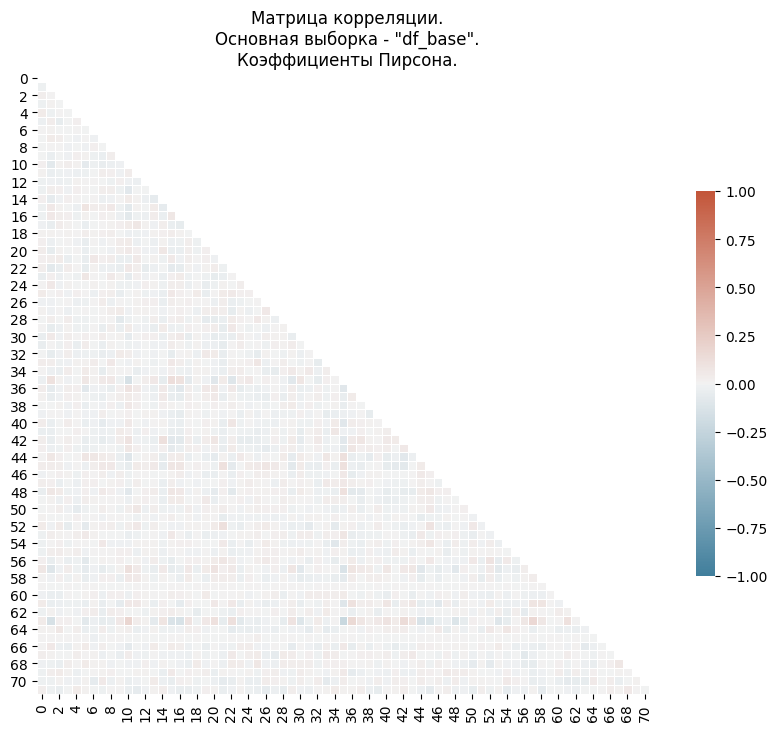

In [15]:
# Определим треугольную маску выводимых значений и цветовую схему.
mask_corr = np.triu(np.ones_like(df_train.corr(numeric_only=True),
                                 dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Выведем матрицы корреляции с коэфф. Пирсона.
plt.figure(figsize=(10, 10))
sns.heatmap(df_base.corr(numeric_only=True), mask=mask_corr, cmap=cmap,
            vmax=1, vmin=-1, square=True, linewidths=.7,
            cbar_kws={"shrink": .5})
plt.title(f'Матрица корреляции.\nОсновная выборка - "df_base".\n'+
          'Коэффициенты Пирсона.')
plt.show();

### Проверка признаков на дискретность.
- Проверим признаки на дискретность, т.к. на графиках видны превалирующие значения в некоторых признаках.

In [16]:
unique_ratio  = (df_base.nunique() / df_base.shape[0])
print('Признаки с менее 10% уникальных значений:')
unique_ratio[unique_ratio < .1].map('{:.2%}'.format)

Признаки с менее 10% уникальных значений:


33    0.14%
44    1.51%
dtype: object

<div style='width: 700px; text-align: justify'>

## Ознакомление с данными, ИАД. Вывод.
- __Размер датасетов:__
  - `df_base`: 2918139 X 72 с идентификаторами объектов в индексе;
  - `df_train`: 100000 X 73, в т.ч. признак ответов, и с идентификаторами объектов в индексе;
  - `df_val`: 100000 X 72 с идентификаторами объектов в индексе;
  - `df_val_answers`: 100000 X 1 - признак ответов с идентификаторами объектов в индексе.
- __Задача ML:__
 <br>Поиск похожих векторов по всему базовому датасету не представляется практичным. <br>
  В связи с этим, рассмотрим алгоритмы
  - кластеризации с поиском `K=5` похожих.
  - кластеризации с поиском $N$ кандидатов и последующим ранжированием для подбора `K=5` похожих.
- __Формат признаков.__
  - Формат признаков соответствует содержанию.
- __Пропуски и дубликаты.__
  - Данные не имеют пропусков и дубликатов за исключением дубликатов списка ответов валидационной выборки `df_val_answer`, которые означают, что одному товару могут соответствовать несколько.
- __Распределение признаков.__
  - Признаки имеют различный масштаб.
  - Признаки `6`, `21`, `25`, `33`, `44`, `59`, `65`, `70` имеют ненормальное распределение. Остальные признаки имеют распределения, приближенные к нормальному.
- __Выбросы / аномалии.__
  - Почти во всех признаках среднее близко к медиане и присутствует минимальный процент выбросов.
  - Признаки `33` и `44` дискретны, возможно категориальны, т.к. имеют менее 1% и 2% уникальнах значений соответственно.
- __Корреляция признаков / мультиколлинеарность.__
  - Корреляция признаков отсутствует.

# Предобработка данных.

## Правка названий признаков.
- Переведём названия признаков и заголовков индексов в нижний регистр.

In [17]:
for df in [df_base, df_train, df_val, df_val_answer]:
    df.index.name = df.index.name.lower()
for df in [df_train, df_val_answer]:
    df.columns = df.columns.str.lower()
for df, name in zip([df_base, df_train, df_val, df_val_answer],
                    ['df_base', 'df_train', 'df_val', 'df_val_answer']):
    print('\033[1mДатафрейм ' + name + ':\033[0m')
    display(df.index.name)
    display(df.columns)
    print('~' * 70, '\n')

Датафрейм df_base:


'id'

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Датафрейм df_train:


'id'

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
       'target'],
      dtype='object')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Датафрейм df_val:


'id'

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Датафрейм df_val_answer:


'id'

Index(['expected'], dtype='object')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



## Разделение `df_train`.
- Запишем ответы `target` обучающей выборки `df_train` в переменную `target_train` и удалим их из датафрейма.
- Проверим результат.

In [18]:
# Запишем ответы обучающей выборки в переменную и удалим их из датафрейма.
target_train = df_train['target']
df_train.drop('target', axis=1, inplace=True)

# Проверим результат.
print('\033[1mВыделенный столбец с ответами для "df_train". Первые'+
      ' 5 строк.\033[0m')
display(target_train.head())
print('~' * 70, '\n')
print('\033[1mПризнаки датафрейма "df_train":')
display(df_train.columns)

Выделенный столбец с ответами для "df_train". Первые 5 строк.


id
0-query     675816-base
1-query     366656-base
2-query    1447819-base
3-query    1472602-base
4-query     717819-base
Name: target, dtype: object

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Признаки датафрейма "df_train":


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

# Кластеризация с поиском `K=5` похожих.

<div style='width: 700px; text-align: justify'>

## Разделимость дискретным признаком.
- Перед проведения других тестов, проверим целесообразность кластеризации/группировки (`groupby`) данных по уникальным значениям дискретных признаков с использованием `NearestNeighbors` для поиска.<br>
>Такая кластеризация являлась бы наиболее осмысленной: например, категориальный признак "тип устройства"/"модель"/"тип продукта"/etc. может естественно разделять товары на кластеры.
- Для теста, возьмём признак `33`, т.к. он обладает наименьшим кол-вом уникальных значений и является дискретным, возможно, категориальным, с наибольшей "вероятностью".
- В рамках теста
  - удалим ненормально распределённые признаки, кроме потенциального разделителя `33`;
  - смасштабируем признаки с помощью `RobustScaler`, устойчивого к выбросам;
  - cоздадим функцию вычисления целевой метрики, которая
    - сгруппирует (`groupby`) данные в кластеры по уникальным значениям признака `33`;
    - в каждом кластере найдёт (`NearestNeighbors`) 5 похожих для каждого объекта в `df_train`;
    - вычислит и выведет целевую метрику.

### Функция кластеризации по уникальным значениям признака.

In [19]:
def search_in_cluster_by_feature(df, df_eval, target, feature, shift = None:
    '''
    Calculates accuracy@5 for clusters based on discrete feature unique values.
    Arguments:
    - df : pd.DataFrame.
    - df_eval : pd.DataFrame. Dataframe with queries.
    - target : list | np.array. List with answers.
    - feature. Name (if numeric) or number of the feature to group by.
      Ex.: '33' | 33.
    - shift : int. Number of deleted features before one to group by.
    '''
    # Соберём идентификаторы, играющие роль центроидов, и кластеры в списки.
    centers_feat = []
    clusters_feat = []
    for center, cluster in df.groupby(feature):
        centers_feat.append(center)
        clusters_feat.append(cluster)

    # Определим экземпляр класса модели поиска похожих.
    nn_5 = NearestNeighbors(n_neighbors=(5))

    # clusters_feat[0]
    index_feat = []
    index_feat_final = []

    # Найдем похожие для каждой записи в обучающей выборке.
    print('Поиск похожих.', '\n', '-----')
    for row in tqdm(df_eval.values):
        i = 0
        # Определим кластер, в котором уникальное значение признака 33
        # совпадает со значением в очередной записи обучающей выборки.
        for i in range(len(centers_feat)):
            if row[int(feature) - shift] == centers_feat[i]:
                # Найдём похожие и запишем их индексы в список.
                if clusters_feat[i].values.shape[0] >= K:
                    nn_5.fit(clusters_feat[i].values)
                    index_feat.append(
                        [i,
                         nn_5.kneighbors(row.reshape(1,-1),
                                         return_distance=False)]
                        )
                else:
                    index_feat.append(
                        [i,
                         np.arange(clusters_feat[i].shape[0])]
                        )

    # Соберём похожие в список.
    print('\nСбор списка.', '\n', '-----')
    for i in tqdm([j[0] for j in index_feat]):
        k_similar = []
        for idx in clusters_feat[
            index_feat[i][0]].iloc[index_feat[i][1].ravel()
            ].index:
            k_similar.append(df.index.get_loc(idx))
        index_feat_final.append(k_similar)

    # Определим базовый индекс.
    base_index = {k: v for k, v in enumerate(df.index.to_list())}

    # Вычислим метрику.
    acc=0
    for t, el in zip(target_train.values.tolist(), index_feat_final):
        acc += int(t in [base_index[r] for r in el])

    return round(100 * acc / len(index_feat_final), 3)

### Кластеризации по уникальным значениям признака `33`.
- Удалим признаки с ненормальным распределением и смасштабируем остальные признаки.
- Вычислим `accuracy@5` для кластеризации по уникальным значениям признака `33`.

In [ ]:
%%time
# Удалим признаки с ненормальным распределением.
cols = ['6', '21', '25', '44', '59', '65', '70']
df_base_t = df_base.drop(cols, axis=1)
df_train_t = df_train.drop(cols, axis=1)

# Cмасштабируем остальные признаки.
rs = RobustScaler()

df_base_t = pd.DataFrame(rs.fit_transform(df_base_t),
                         columns=df_base_t.columns,
                         index=df_base_t.index)
df_train_t = pd.DataFrame(rs.transform(df_train_t),
                          columns=df_train_t.columns,
                          index=df_train_t.index)

# Вычислим `accuracy@5` для кластеризации по признаку `33`.
acc_33 = search_in_cluster_by_feature(df_base_t,
                                      df_train_t,
                                      target_train, '33', 3)

print('Целевая метрика "accuracy@5" при разделении по уникальным '+
      f'значениям признака "33": {acc_33}')
print('\n')

<div style='width: 700px; text-align: justify'>

### Разделимость дискретным признаком. Вывод.
- Вывод неутешителен: `accuracy@5` = 0, признак `33` не способен разделить данные на осмысленные кластеры.
- Продолжим тестирование.

<div style='width: 700px; text-align: justify'>

## Базовые модели.
Для проведения тестов используем базовые модели `FAISS` с индексом `IVFx,Flat` и `ANNOY`, т.к. они значительно превосходят связку `KMeans` + `NearestNeighbors` в скорости.
- Принцип работы `FAISS`:
  - Создание инвертированного индекса.
  - Поиск похожих сначала по центроидам, затем по выбранным кластерам.
- Принцип работы `ANNOY`:
  - Создание индекса из леса бинарных деревьев, состоящих из итеративно разделённых равноудалёнными гиперплоскостями пространств.
  - Поиск похожих спуском по деревьям со сравнением узлов с искомым вектором.<br>

<div style='width: 700px; text-align: justify'>

### Функция вычисления accuracy@k для `FAISS`, `ANNOY`.

Введём функцию, которая
- примет на вход
  - датафрейм со всеми объектами для составления индексов;
  - датафрейм с объектами для поиска похожих;
  - признак с ответами - разметкой предыдущего датафрейма;
  - тип модели: `FAISS`, `ANNOY`;
  - для модели `FAISS`:
    - кол-во кластеров;
    - тип индекса:
      - `IVFx,Flat` - неисчерпывающий "медленный" индекс, создающийся по принципу: "меньше больши́х кластеров";
      - `IVFx_HNSWM,Flat` - неисчерпывающий индекс, рекомендуемый разработчиками как одна из альтернатив для выборки размером 1-10млн. объектов и создающийся по принципу: "больше малых кластеров";
    - метрику (макс. скалярное произведение, косинусное сходство) / тип оцениваемого расстояния (Евклидово, Махаланобиса);
    - размер выборки для обучения;
    - кол-во признаков в результирующем датафрейме, которое является меткой необходимости снижения размерности встроенным методом `PCA`;
    - кол-во связей на центроид `M` для индекса `IVFx_HNSWM,Flat`;
    - глубина поиска `efSearch` для индекса `IVFx_HNSWM,Flat`;
    - кол-во кластеров, посещаемое во время поиска `nprobe`;
  - для модели `ANNOY`:
    -  метрику (скалярное произведение) / тип оцениваемого расстояния (Евклидово, Махаланобиса, Манхэеттенское, Хэмминга, косинусное);
    - кол-во деревьев;
    - кол-во узлов для поиска;
  - кол-во искомых похожих объектов.
- создаст индекс(ы) для заданного расстояния и кол-ва кластеров / деревьев.
- вычислит и выведет целевую метрику `accuracy@k` для искомых `k` похожих объектов для всех объектов переданного датафрейма и время поиска;
- опционально выведет индекс.

In [21]:
# Функция вычисления целевой метрики accuracy@k.
def get_accuracy(df, df_eval, target,
                 model_type = None,
                 faiss_n_clust = None,
                 faiss_index = 'ivf_flat',
                 faiss_metric = 'euclidean',
                 faiss_train_sample_size = None,
                 faiss_pca_dims = None,
                 faiss_m = 32,
                 faiss_ef_search = None,
                 faiss_nprobe = 1,
                 annoy_metric = 'euclidean',
                 annoy_n_trees = 10,
                 annoy_search_n_nodes = -1,
                 k_similar = K,
                 return_index = False,
                 SEED = 42):
    '''
    Builds index with specified model(s). Calculates accuracy@k and index
    search time.
    Arguments.
    - df : pd.DataFrame. Dataframe to find similars in.
    - df_eval : pd.DataFrame. Dataframe with samples to find similars for.
    - target : pd.Series or array. Columns with answers for df_eval.
    - model_type : str | list. Either 'faiss' or 'annoy' or both in list.
    - FAISS:
        - faiss_n_clust : int. Number of clusters for FAISS.
        - faiss_index : str. Type of index to build.
          Accepts:
            - 'ivf_flat' for IVFFlat index;
            - 'ivf_hnsw' for IVFHNSWFlat index with assignable number of
            clusters and entry points.
        - faiss_metric : str. Metric / distance type for FAISS.
          For IVFFLAT index accepts:
            - 'euclidean';
            - 'mahalanobis';
            - 'cosine';
            - 'mips' - maximum inner product search.
        - faiss_train_sample_size : int. FAISS train sample size.
        - faiss_pca_dims : int. If present, PCA dimensionality reduction is
          performed with the specified number of desired output features.
        - faiss_m : int. Number of connections per centroid for IVFHNSW index.
        - faiss_nprobe : int. Number of clusters to visit while searching.
    - ANNOY:
        - annoy_metric : str.
          Accepts:
            - 'euclidean';
            - 'angular' for cosine distance;
            - 'manhattan';
            - 'hamming';
            - 'dot'.
        - annoy_n_trees : int. Number of trees for ANNOY index.
        - annoy_search_n_nodes : int. Number of nodes to search.
    - k_similar : int. Number of similar objects t search for.
    - return_index : bool. Whether to return the index.
    - SEED : any. RNG seed.
    '''

    # Изменим формат типа модели при необходимости.
    model_type = [model_type] if isinstance(model_type, str) else model_type

    # Определим длину вектора признаков.
    dims = df.shape[1]

    # Определим базовый индекс.
    base_index = {k: v for k, v in enumerate(df.index.to_list())}

    # FAISS
    if 'faiss' in model_type:
        # FAISS с PCA
        if faiss_pca_dims:
            # Снизим размерность данных и приведём данные в соответствие faiss.
            pca_matrix = faiss.PCAMatrix(dims, faiss_pca_dims)
            pca_matrix.train(df)
            assert pca_matrix.is_trained
            df_arr = pca_matrix.apply(df)
            df_eval_arr = pca_matrix.apply(df_eval)

            dims = faiss_pca_dims

        # FAISS с индексом IVFFLAT.
        if faiss_index == 'ivf_flat':
            # Определим квантизатор.
            quantizer = faiss.IndexFlatL2(dims)

            # FAISS с расстоянием Махаланобиса.
            if faiss_metric == 'mahalanobis':
                if faiss_pca_dims:
                    df = df_arr
                    df_eval = df_eval_arr
                # Вычислим матрицу ковариации.
                df_c = df - df.mean(0)
                cov = np.dot(df_c.T, df_c) / df_c.shape[0]

                # Преобразуем ковариационную матрицу.
                L = np.linalg.cholesky(cov)
                mahalanobis_transform = np.linalg.inv(L)

                # Функция преобразования данных.
                def inverse_cholesky_cov(df, mahalanobis_transform):
                    df_trans = np.dot(df, mahalanobis_transform.T)
                    return df_trans.astype('float32')

                # Преобразуем данные.
                df_arr = inverse_cholesky_cov(df,
                                              mahalanobis_transform)
                df_eval_arr = inverse_cholesky_cov(df_eval,
                                                   mahalanobis_transform)

                # Определим индекс.
                faiss_index = faiss.IndexIVFFlat(quantizer,
                                                 dims,
                                                 faiss_n_clust,
                                                 faiss.METRIC_L2)

            else:
                # Приведём данные в соответствие faiss,
                # если не был проведён PCA.
                if not faiss_pca_dims:
                    df_arr = np.ascontiguousarray(df.values).astype('float32')
                    df_eval_arr = (
                        np.ascontiguousarray(df_eval.values).astype('float32')
                        )

                # FAISS с косинусным сходством.
                if faiss_metric == 'cosine':

                    # Нормализуем векторы.
                    faiss.normalize_L2(df_arr)
                    faiss.normalize_L2(df_eval_arr)

                    # Определим индекс.
                    faiss_index = faiss.IndexIVFFlat(quantizer,
                                                    dims,
                                                    faiss_n_clust,
                                                    faiss.METRIC_INNER_PRODUCT)

                # FAISS с поиском максимального скалярного произведения.
                elif faiss_metric == 'mips':

                    # Определим индекс.
                    faiss_index = faiss.IndexIVFFlat(quantizer,
                                                    dims,
                                                    faiss_n_clust,
                                                    faiss.METRIC_INNER_PRODUCT)

                # FAISS с Евклидовым расстоянием.
                elif faiss_metric == 'euclidean':

                    # Определим индекс.
                    faiss_index = faiss.IndexIVFFlat(quantizer,
                                                    dims,
                                                    faiss_n_clust)

                else:
                    raise ValueError('Другие метрики "FAISS" не '+
                                     'поддерживаются.')

        # FAISS с индексом IVFHNSW.
        elif faiss_index == 'ivf_hnsw':
            #  Приведём данные в соответствие faiss, если не был проведён PCA.
            if not faiss_pca_dims:
                df_arr = np.ascontiguousarray(df.values).astype('float32')
                df_eval_arr = (
                    np.ascontiguousarray(df_eval.values).astype('float32')
                    )

            # Определим индекс.
            faiss_index = faiss.index_factory(dims,
                                              (f'IVF{faiss_n_clust}_HNSW'+
                                               f'{faiss_m}'+',Flat'))
            if faiss_ef_search:
                faiss_index.efSearch = faiss_ef_search

        start_faiss = perf_counter()

        # Обучим и построим индекс FAISS.
        faiss_index.train(df_arr[:faiss_train_sample_size, :])
        faiss_index.add(df_arr)

        faiss_index.nprobe = faiss_nprobe

        # Построим список с индексами похожих.
        _, idx = faiss_index.search(df_eval_arr, k_similar)

        # Вычислим целевую метрику accuracy@k для FAISS.
        acc_faiss = 0
        for t, el in zip(target.values.tolist(), idx):
            acc_faiss += int(t in [base_index[r] for r in el])

        # Вычислим время выполнения.
        time_faiss = perf_counter() - start_faiss

    # ANNOY
    if 'annoy' in model_type:

        # Определим индекс ANNOY.
        annoy_index = AnnoyIndex(dims, annoy_metric)
        annoy_index.set_seed(SEED)
        # Добавим векторы и их индексы.
        for i, v in zip(range(df.shape[0]), df.values):
            annoy_index.add_item(i, v)

        # Построим индекс.
        annoy_index.build(annoy_n_trees, n_jobs=-1)

        start_annoy = perf_counter()

        # Получим и соберём в список K похожих элементов для каждого запроса.
        idx = []
        for v in df_eval.values:
            idx.append(annoy_index.get_nns_by_vector(
                v,
                k_similar,
                search_k=annoy_search_n_nodes)
            )

        # Вычислим целевую метрику accuracy@k для ANNOY.
        acc_annoy = 0
        for t, el in zip(target.values.tolist(), idx):
            acc_annoy += int(t in [base_index[r] for r in el])

        # Вычислим время выполнения.
        time_annoy = perf_counter() - start_annoy

    # Выведем метрику и время исполнения для каждого/всех алгоритмов с выводом
    # индекса при необходимости.
    # Только FAISS.
    if model_type == ['faiss'] and return_index:
        return (round((100 * acc_faiss / len(idx)), 3),
                round(time_faiss, 2),
                idx)

    elif model_type == ['faiss'] and not return_index:
        return (round((100 * acc_faiss / len(idx)), 3),
                round(time_faiss, 2))
    # Только ANNOY.
    elif model_type == ['annoy'] and return_index:
        return (round((100 * acc_annoy / len(idx)), 3),
                round(time_annoy, 2),
                idx)

    elif model_type == ['annoy'] and not return_index:
        return (round((100 * acc_annoy / len(idx)), 3),
                round(time_annoy, 2))
    # FAISS и ANNOY.
    elif all(model in model_type for model in ['faiss', 'annoy']) and \
    return_index:
        return (round((100 * acc_faiss / len(idx)), 3), round(time_faiss, 2),
                round((100 * acc_annoy / len(idx)), 3), round(time_annoy, 2),
                idx)

    elif all(model in model_type for model in ['faiss', 'annoy']) and not \
    return_index:
        return (round((100 * acc_faiss / len(idx)), 3), round(time_faiss, 2),
                round((100 * acc_annoy / len(idx)), 3), round(time_annoy, 2))

<div style='width: 700px; text-align: justify'>

### Базовые модели. Первичные оценки.
- Получим первичные значения целевой метрики `acuracy@5` на базовых моделях с произвольно выбранным кол-вами кластеров и деревьев для сравнения со значениями при проведении тестов.
- Размер выборки для обучения `FAISS` для всех тестов установим в не менее 10% от общего кол-ва объектов в основной выборке в соответствии с вычисленным ранее репрезентативным процентом выборки.

In [22]:
%%time
# Получим первичные значения целевой метрики acuracy@5 на базовых моделях.
(acc_faiss, time_faiss,
 acc_annoy, time_annoy)  = get_accuracy(
      df=df_base, df_eval=df_train, target=target_train,
      model_type=['faiss', 'annoy'],
      faiss_n_clust = 100,
      faiss_train_sample_size = int(df_base.shape[0] * .1),
      annoy_n_trees = 50
      )

# Создадим и выведем таблицу с результатами.
columns = pd.MultiIndex.from_tuples((('Модель FAISS', 'accuracy@5:'),
                                    ('Модель FAISS', 'Время поиска (сек.):'),
                                    ('Модель ANNOY', 'accuracy@5:'),
                                    ('Модель ANNOY', 'Время поиска (сек.):')))

base_results = pd.DataFrame([[acc_faiss, time_faiss, acc_annoy, time_annoy]],
                           columns=columns, index=[''])
display(base_results
        .style
        .format(precision=3)
        .set_caption('Первичные оценки базовых моделей.')
        .set_table_styles(styles))
print('\n')



CPU times: total: 18min 34s
Wall time: 2min 32s


#### Первичные оценки. Вывод.
Значения целевой метрики для двух базовых алгоритмов неудовлетворительны.<br> Проведём тесты и попытаемся улучшить эти значения.

<div style='width: 700px; text-align: justify'>

### Базовые модели. Удаление признаков.
- Т.к. обработка признаков с ненормальным распределением и/или признаков с некоторым кол-вом часто встречающихся значений без понимания их происхождения может быть проблематичной, проверим метрику `accuracy@5` на базовых моделях, при поочерёдном/полном удалении признаков:
`6`, `21`, `25`, `33`, `44`, `59`, `65`, `70`.

In [23]:
%%time
# Запишем поочерёдно/полностью удаляемые признаки в переменную.
cols = ['6', '21', '25', '33', '44', '59', '65', '70']
cols.append(cols[:])

# Проверим метрику accuracy@5 на базовых моделях с поочерёдным/полным
# удалением ненормальных признаков.
normal_feats_results_list = []
for col in tqdm(['6', '21', '25', '33', '44', '59', '65', '70',
                 ['6', '21', '25', '33', '44', '59', '65', '70']]):
    df_base_t = df_base.drop(col, axis=1)
    df_train_t = df_train.drop(col, axis=1)

    # Получим значения целевой метрики acuracy@5 на базовых моделях.
    (acc_faiss, time_faiss,
     acc_annoy, time_annoy)  = get_accuracy(
          df=df_base_t,
          df_eval=df_train_t,
          target=target_train,
          model_type=['faiss', 'annoy'],
          faiss_n_clust = 100,
          faiss_train_sample_size = int(df_base.shape[0] * .1),
          annoy_n_trees = 50
          )

    normal_feats_results_list.append([col,
                                      acc_faiss, time_faiss,
                                      acc_annoy, time_annoy])

# Удалим вложенный дубликат удаляемых признаков из оригинального
# признака для посл. использования.
cols = cols[:-1]

# Создадим и выведем таблицу с результатами.
columns = pd.MultiIndex.from_tuples(
    (('Модель FAISS', 'Удалённые признаки:'),
     ('Модель FAISS', 'accuracy@5:'),
     ('Модель FAISS', 'Время поиска (сек.):'),
     ('Модель ANNOY', 'accuracy@5:'),
     ('Модель ANNOY', 'Время поиска (сек.):')))

normal_feats_results = pd.DataFrame(normal_feats_results_list,
                                    columns=columns)
print('\n')
display(normal_feats_results
        .style
        .format(precision=3)
        .set_caption('Оценки базовых моделей с удалением\n '+
                     'ненормально распределённых признаков.')
        .set_table_styles(styles))
print('\n')

  0%|          | 0/9 [00:00<?, ?it/s]



CPU times: total: 2h 47min 41s
Wall time: 22min 31s


<div style='width: 700px; text-align: justify'>

#### Удаление признаков. Вывод.
- При удалении всех ненормально распределённых признаков целевая метрика значительно возрастает.
- Признаки `6`, `70` необходимо попытаться сохранить, т.к. при их удалении целевая метрика относительно сильно снижается.
- Остальные признаки с ненормальным распределением, ухудшающие или не влияющие на целевую метрику, необходимо удалить, т.к. обработка таких признаков без понимания их происхождения представляется проблематичной.

Протестируем варианты удаления признаков в следующем разделе.

<div style='width: 700px; text-align: justify'>

## Масштабирование и удаление признаков.
Смасштабируем признаки, т.к. модели, измеряющие расстояние, в т.ч. `KMeans`, `NN` и `ANN` (`FAISS`, `ANNOY`), чувствительны к разному масштабу признаков.

<div style='width: 700px; text-align: justify'>

### Тестирование методов масштабирования и удаление признаков.
- Протестируем следующие варианты масштабирования:
  - Вариант 1:
    - Удаление признаков с ненормальным распределением.
    - Масштабирование с использованием `RobustScaler`.
  - Вариант 2:
    - Трансформация распределения признаков `6`, `70` в нормальное с использованием `QuantileTransformer`.
    - Замена одномерных выбросов средним по признаку.
    - Масштабирование с помощью `StandardScaler`.

#### Вариант 1:
  - Удалим признаки с ненормальным распределением.
  - Смасштабируем все признаки с использованием `RobustScaler`.

In [24]:
%%time
# Запишем датафреймы с удалёнными признаками в переменные.
df_base_t = df_base.drop(cols, axis=1)
df_train_t = df_train.drop(cols, axis=1)

# Зададим экземпляр класса алгоритма масштабирования.
rs = RobustScaler()

# Смасштабируем признаки и запишем их в датафреймы.
df_base_t = pd.DataFrame(rs.fit_transform(df_base_t),
                         columns=df_base_t.columns,
                         index=df_base_t.index)
df_train_t = pd.DataFrame(rs.transform(df_train_t),
                          columns=df_train_t.columns,
                          index=df_train_t.index)

# Получим значения целевой метрики acuracy@5.
(acc_faiss, time_faiss,
 acc_annoy, time_annoy)  = get_accuracy(
     df=df_base_t,
     df_eval=df_train_t,
     target=target_train,
     model_type=['faiss', 'annoy'],
     faiss_n_clust = 100,
     faiss_train_sample_size = int(df_base.shape[0] * .1),
     annoy_n_trees = 50
 )

# Создадим и выведем таблицу с результатами.
columns = pd.MultiIndex.from_tuples(
    (('Модель FAISS', 'Удалённые признаки:'),
     ('Модель FAISS', 'accuracy@5:'),
     ('Модель FAISS', 'Время поиска (сек.):'),
     ('Модель ANNOY', 'accuracy@5:'),
     ('Модель ANNOY', 'Время поиска (сек.):'))
)

scale_results_1 = pd.DataFrame([[cols,
                                 acc_faiss, time_faiss,
                                 acc_annoy, time_annoy]],
                               columns=columns)
display(scale_results_1
        .style
        .format(precision=3)
        .set_caption('Оценки базовых моделей \nс удалением признаков. '+
                     'Вариант 1.')
        .set_table_styles(styles))
print('\n')



CPU times: total: 17min 48s
Wall time: 2min 24s


<div style='width: 700px; text-align: justify'>

#### Вариант 2:
  - Преобразуем распределения признаков `6`, `70` в приближенные к нормальным с использованием `QuantileTransformer`.
  - Введём функцию замены одномерных выбросов средним по признаку, которая
    -  примет датафрейм и кол-во $\sigma$ для определения и замены выбросов <br>
    (по умолчанию 2.7$\sigma$, в соответствии с диаграммой размаха);
    -  вернет преобразованный датафрейм.
  - Смасштабируем все признаки с помощью `StandardScaler`.

In [25]:
# Функция замены выбросов на средние значения.
def outliers_to_means(df, n_sigma=2.7):
    df_t = df.mask(~zscore(df).abs().lt(n_sigma))
    df_t = df_t.apply(lambda x: x.fillna(x.median()))
    return df_t

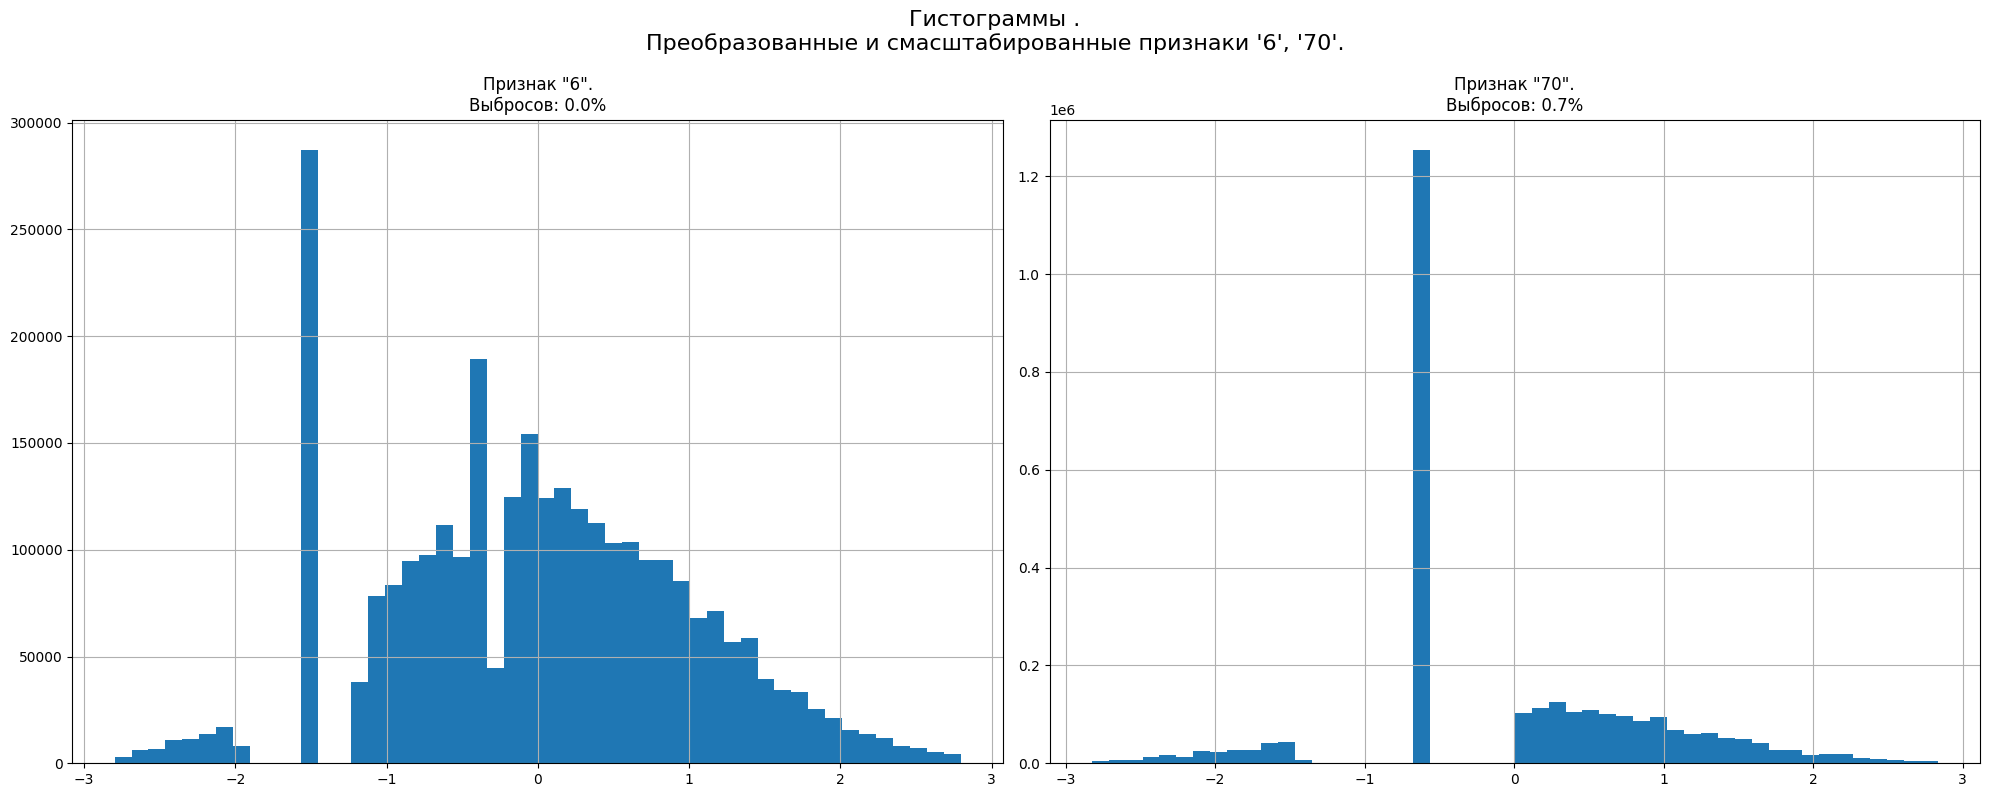

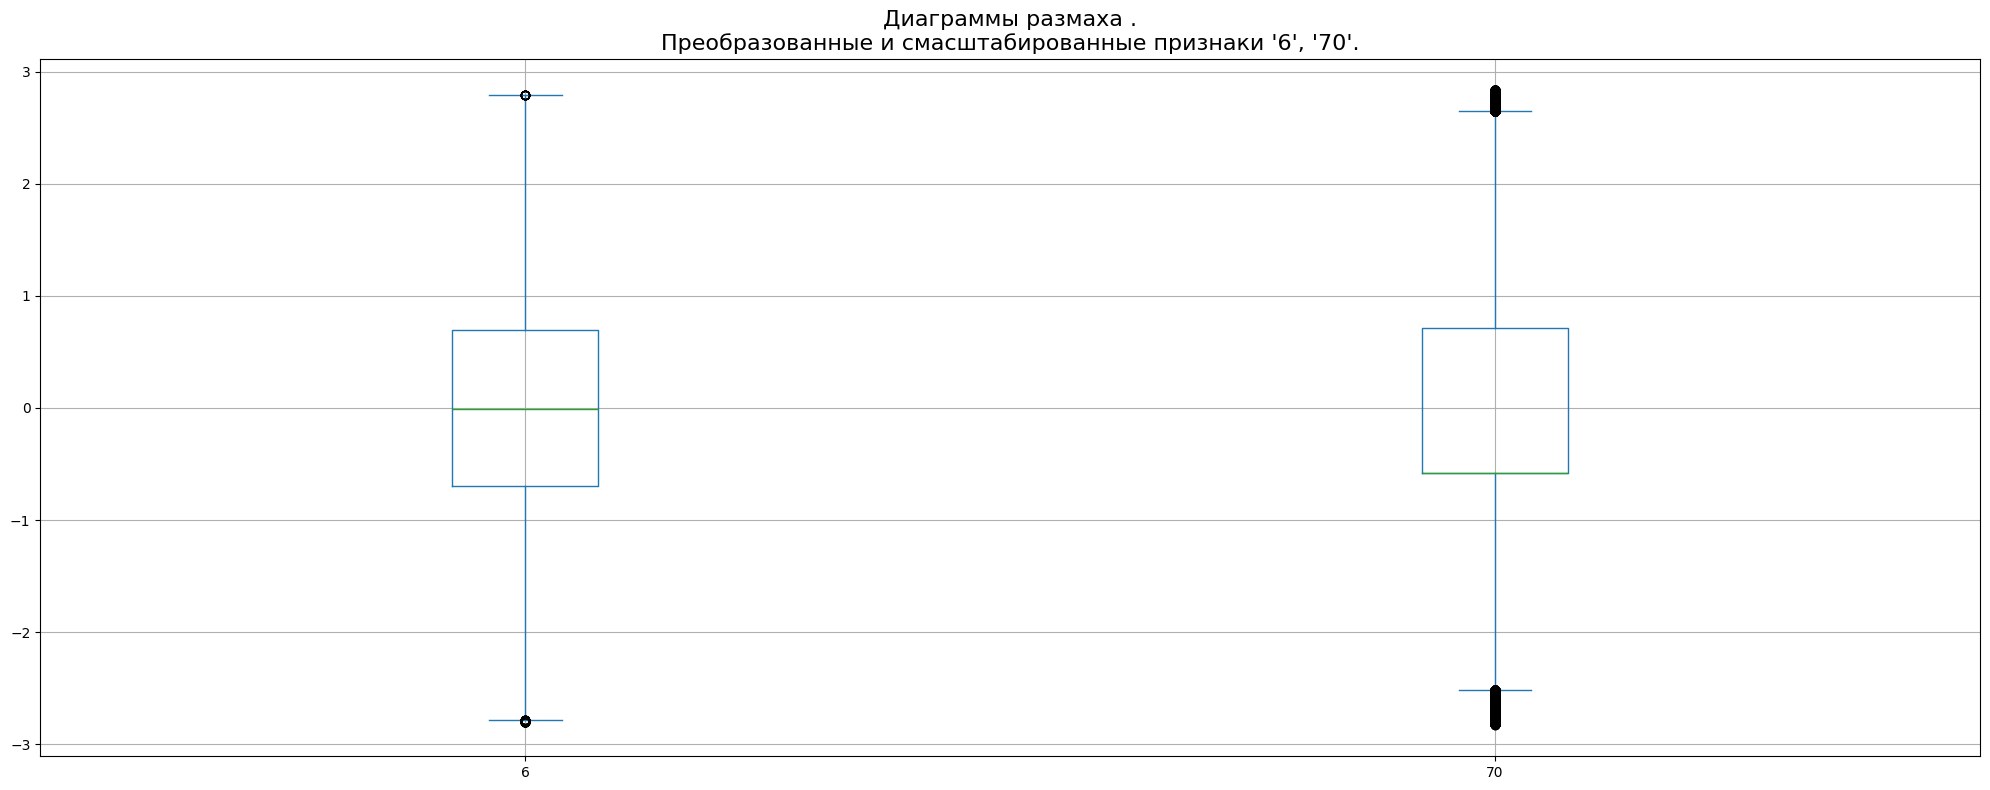



CPU times: total: 18min 17s
Wall time: 2min 33s


In [26]:
%%time
# Запишем датафреймы с удалёнными признаками в переменные.
cols_partial = ['21', '25', '33', '44', '59', '65']
cols_to_qt = ['6', '70']
df_base_t = df_base.drop(cols_partial, axis=1)
df_train_t = df_train.drop(cols_partial, axis=1)

# Зададим экземпляр класса алгоритмов трансформации
# и масштабирования.
qt = QuantileTransformer(n_quantiles=10000,
                         output_distribution='normal',
                         random_state=SEED)
ss = StandardScaler()

# Переведём признаки 6 и 70 в распределение близкое к нормальному.
df_base_t[cols_to_qt] = pd.DataFrame(
    qt.fit_transform(df_base_t[cols_to_qt]),
    columns=cols_to_qt, index=df_base_t.index
)
df_train_t[cols_to_qt] = pd.DataFrame(
    qt.transform(df_train_t[cols_to_qt]),
    columns=cols_to_qt, index=df_train_t.index
)

# Удалим выбросы.
df_base_t = outliers_to_means(df_base_t)
df_train_t = outliers_to_means(df_train_t)

# Смаштабируем признаки.
df_base_t = pd.DataFrame(ss.fit_transform(df_base_t),
                         columns=df_base_t.columns,
                         index=df_base_t.index)
df_train_t = pd.DataFrame(ss.transform(df_train_t),
                          columns=df_train_t.columns,
                          index=df_train_t.index)

# Выведем графики.
get_eda_plots(
    df_base_t[cols_to_qt],
    ('.\nПреобразованные и смасштабированные признаки '+
     str(cols_to_qt).strip("[]"))
)
print('\n')

# Получим значения целевой метрики acuracy@5.
(acc_faiss, time_faiss,
 acc_annoy, time_annoy)  = get_accuracy(
      df=df_base_t, df_eval=df_train_t, target=target_train,
      model_type=['faiss', 'annoy'],
      faiss_n_clust = 100,
      faiss_train_sample_size = int(df_base.shape[0] * .1),
      annoy_n_trees = 50
      )

# Создадим и выведем таблицу с результатами.
columns = pd.MultiIndex.from_tuples(
    (('Модель FAISS', 'Удалённые признаки:'),
     ('Модель FAISS', 'accuracy@5:'),
     ('Модель FAISS', 'Время поиска (сек.):'),
     ('Модель ANNOY', 'accuracy@5:'),
     ('Модель ANNOY', 'Время поиска (сек.):'))
)

scale_results_2 = pd.DataFrame([[cols_partial,
                                 acc_faiss, time_faiss,
                                 acc_annoy, time_annoy]],
                               columns=columns)
display(scale_results_2
        .style
        .format(precision=3)
        .set_caption('Оценки базовых моделей \nс удалением признаков. '+
                     'Вариант 2.')
        .set_table_styles(styles))
print('\n')

<div style='width: 700px; text-align: justify'>

### Масштабирование признаков.
- Остановимся на Варианте 1, масштабировании с использованием `RobustScaler` и удалении признаков с ненормальными распределениями, т.к. он показал лучший результат.
  - Удалим признаки, с ненормальным распределеним: `6`, `21`, `25`, `33`, `44`, `59`, `65`, `70`.
  - Смасштабируем признаки, используя `RobustScaler`, устойчивый к выбросам, методом `fit_transform` для основного датафрейма и `transform` для двух остальных.
  - Выведем гистограммы и диаграммы размаха результирующих датафреймов для проверки.
- Добавим к результирующим датафреймам окончание `_rs` для индикации изменений.
- Удалим временные переменные `df_base_t`, `df_train_t`.

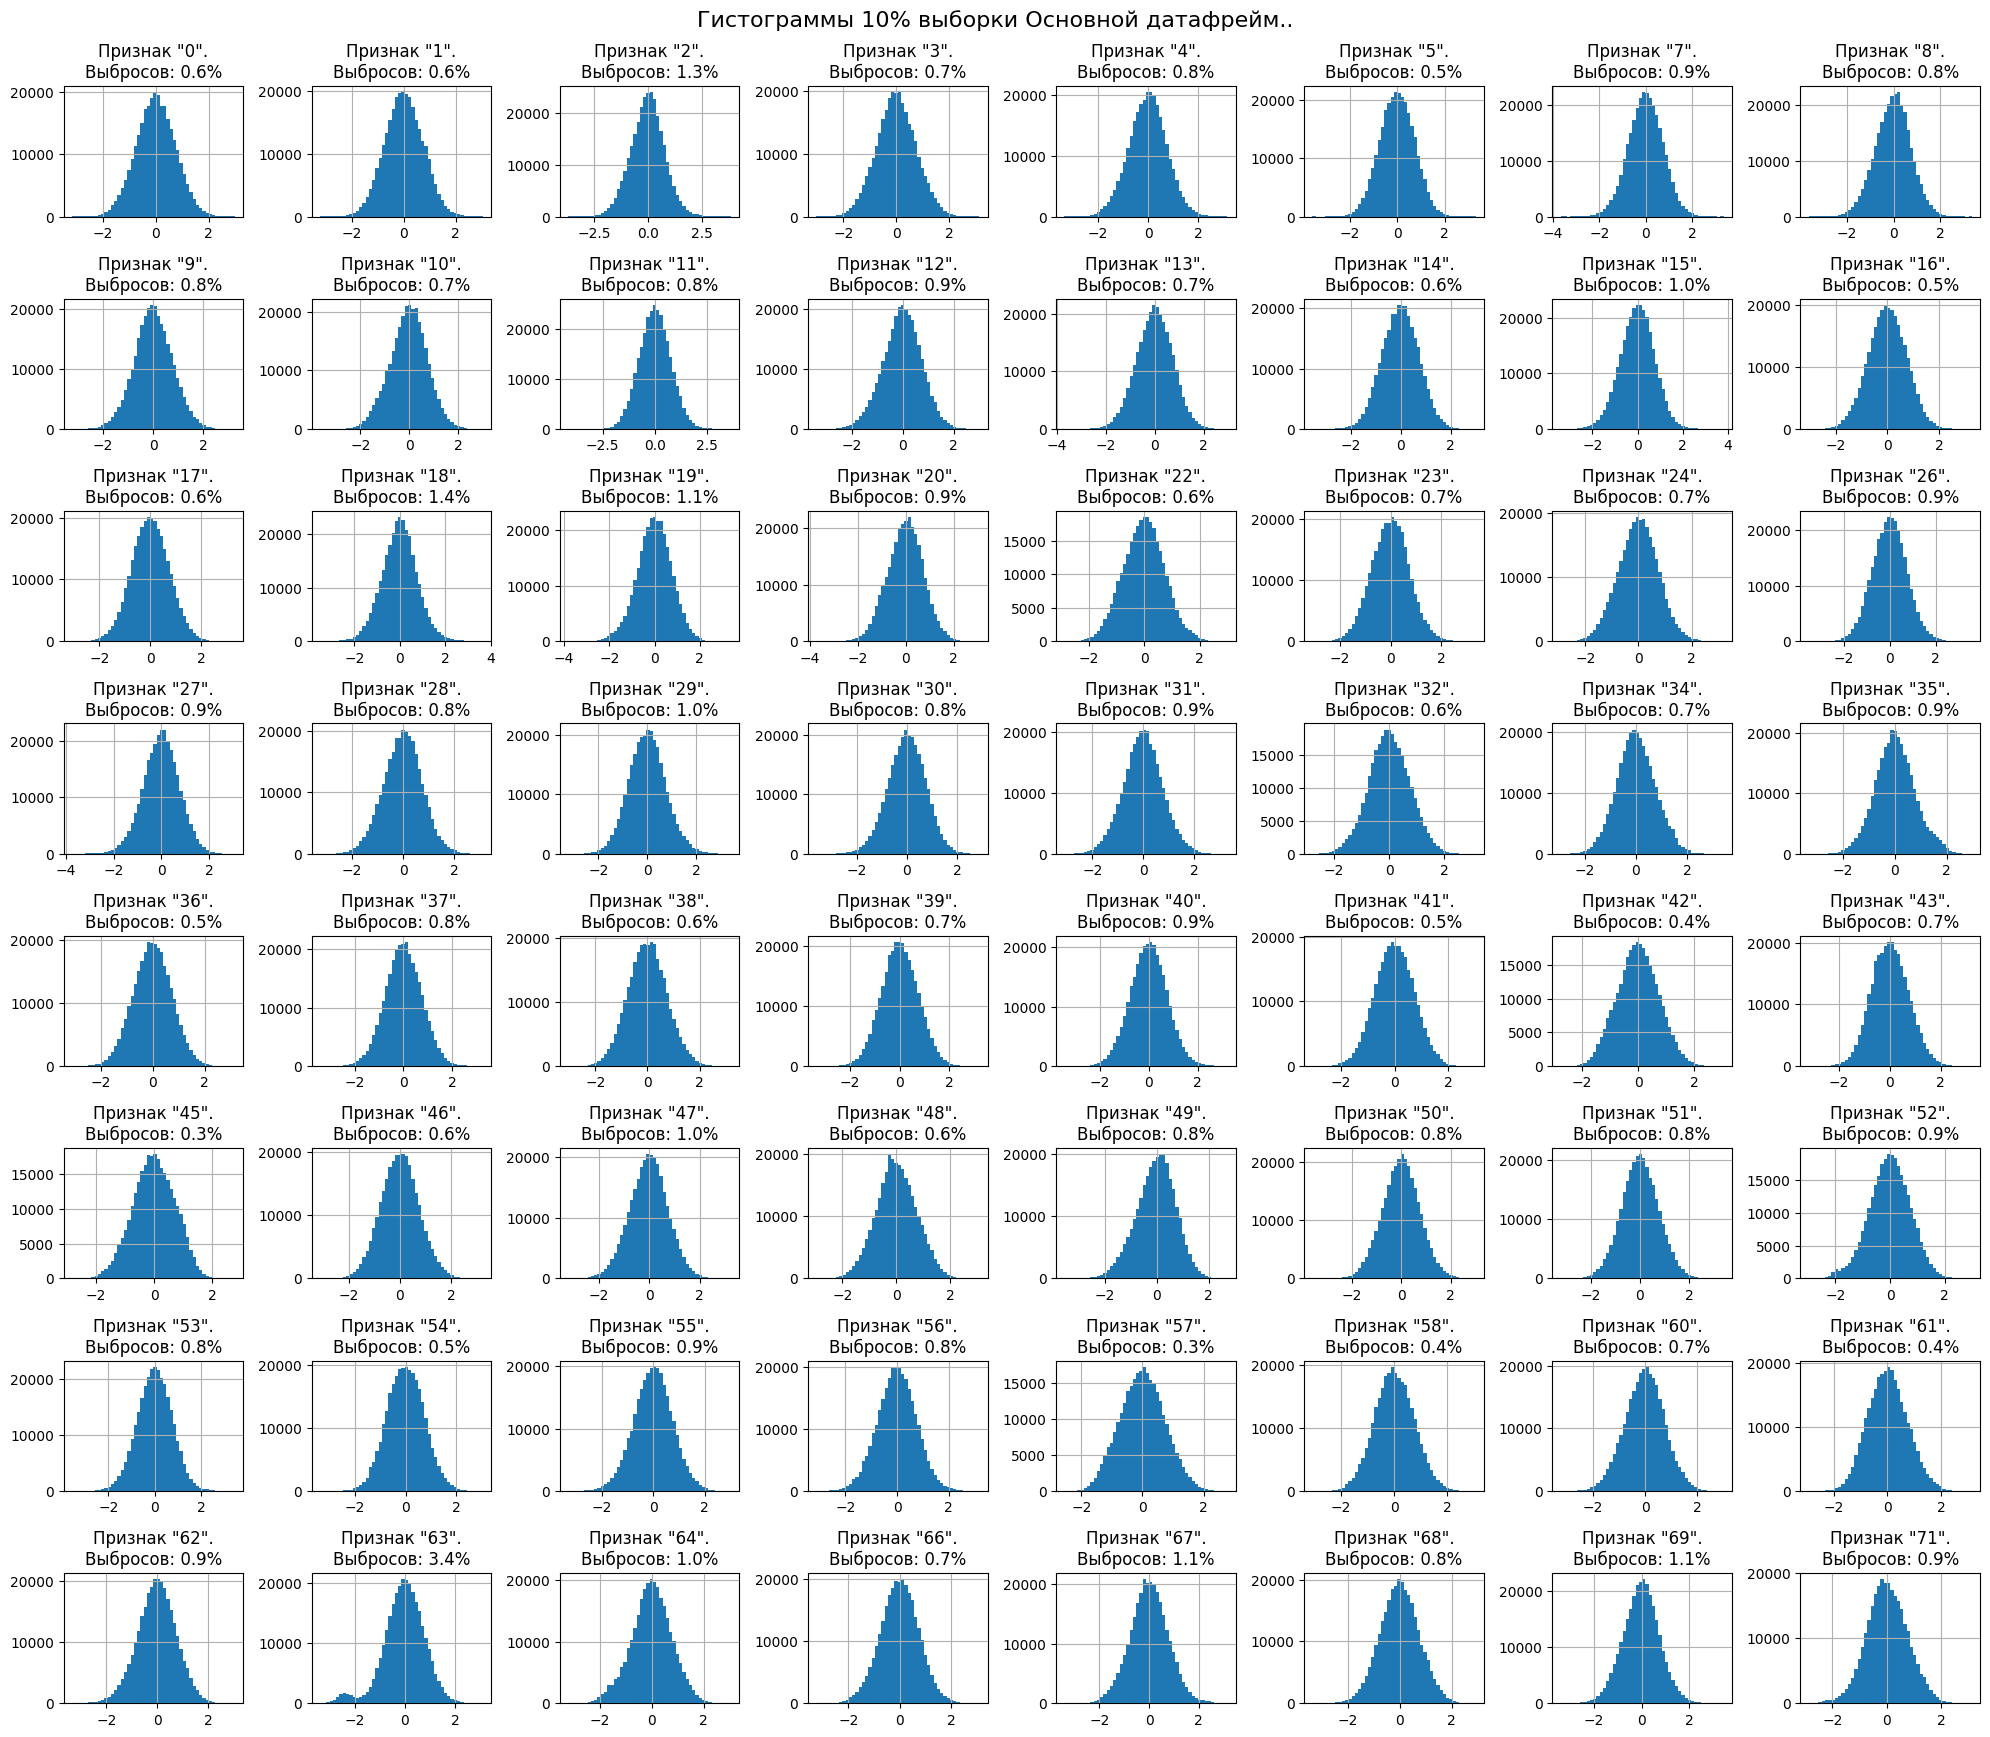

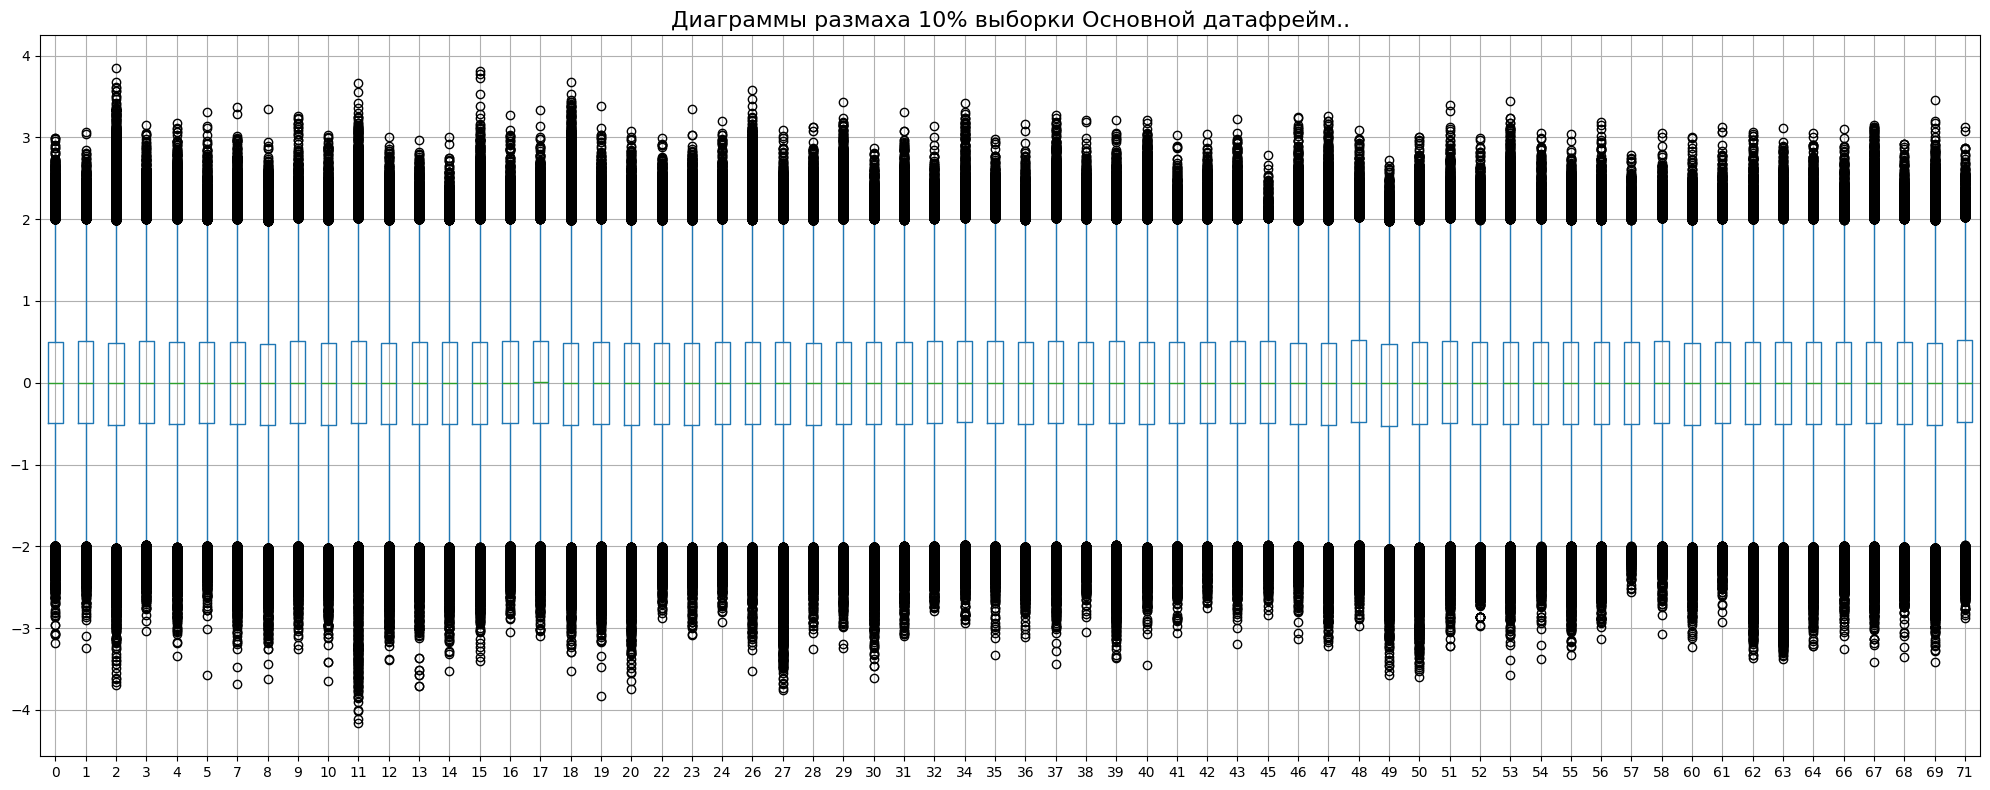

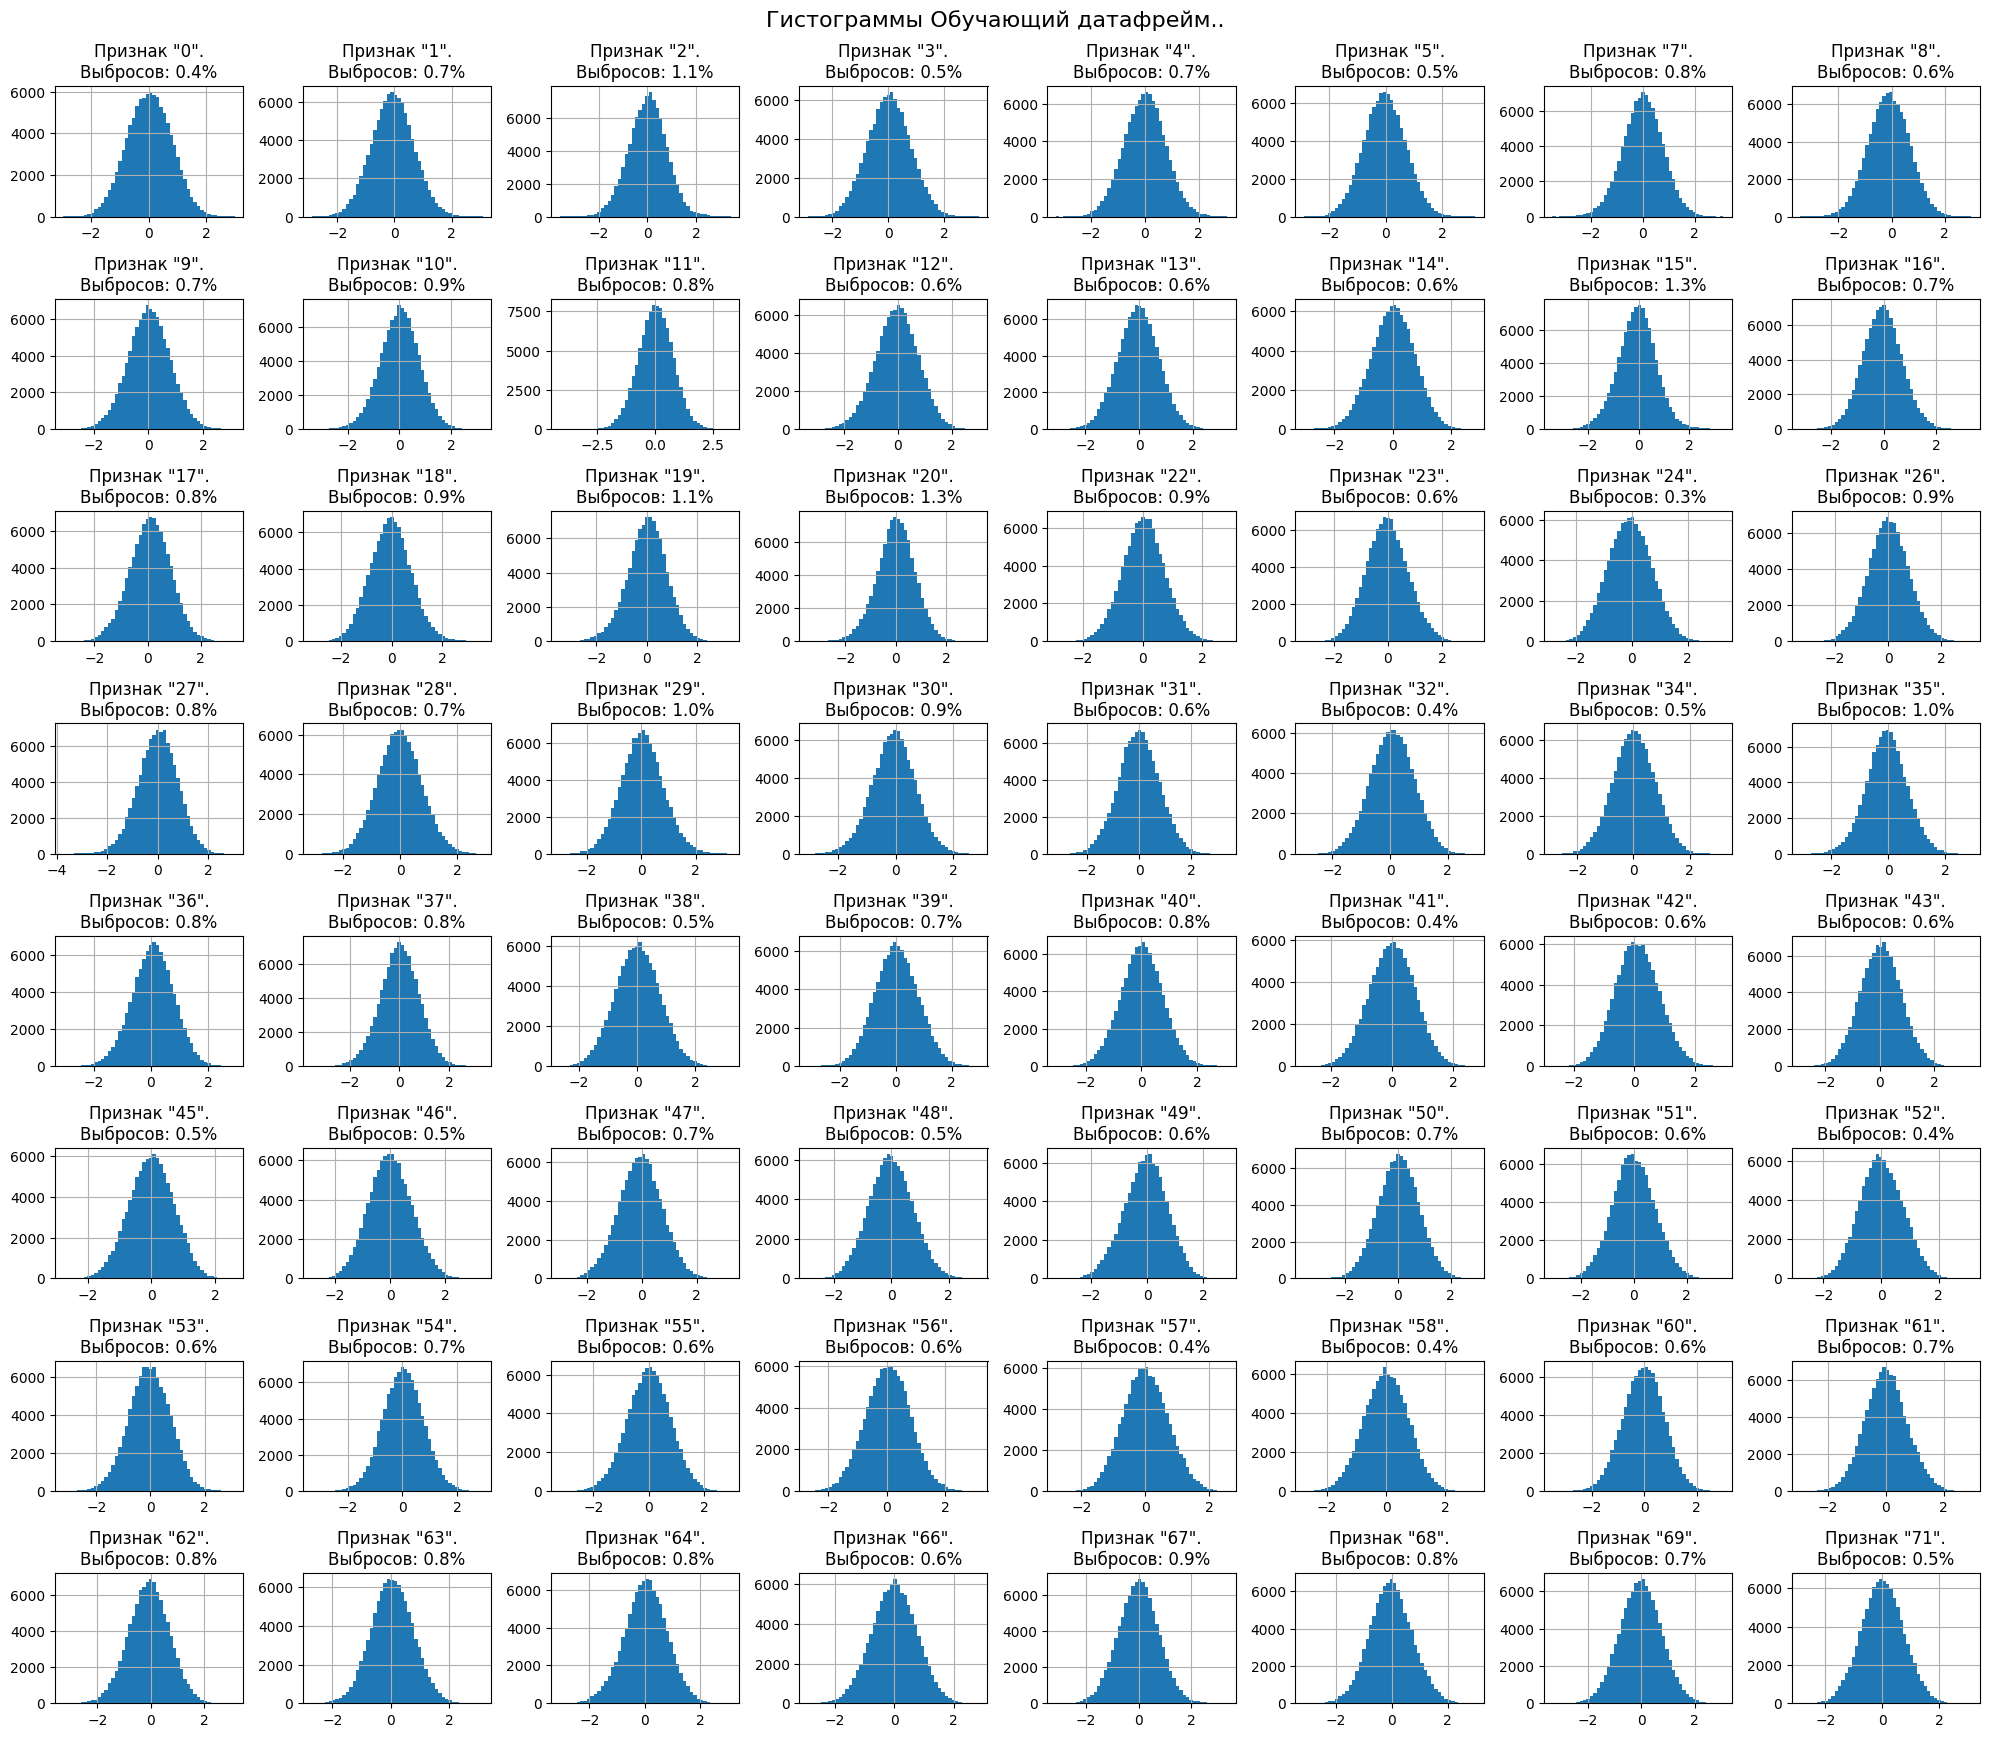

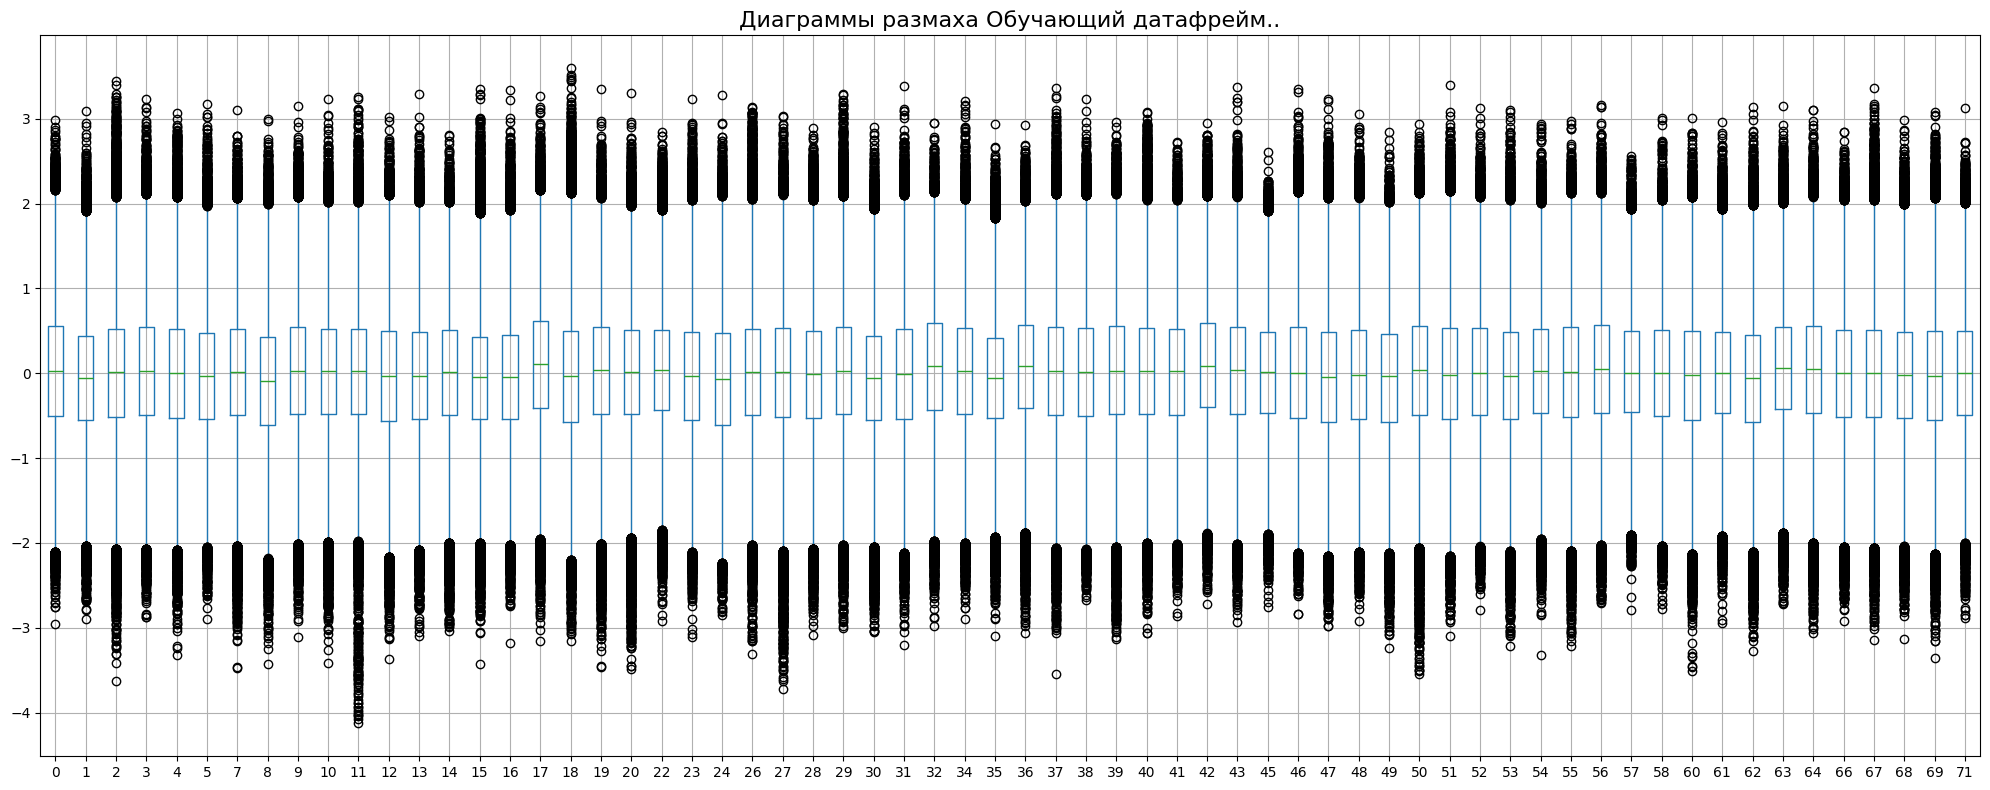

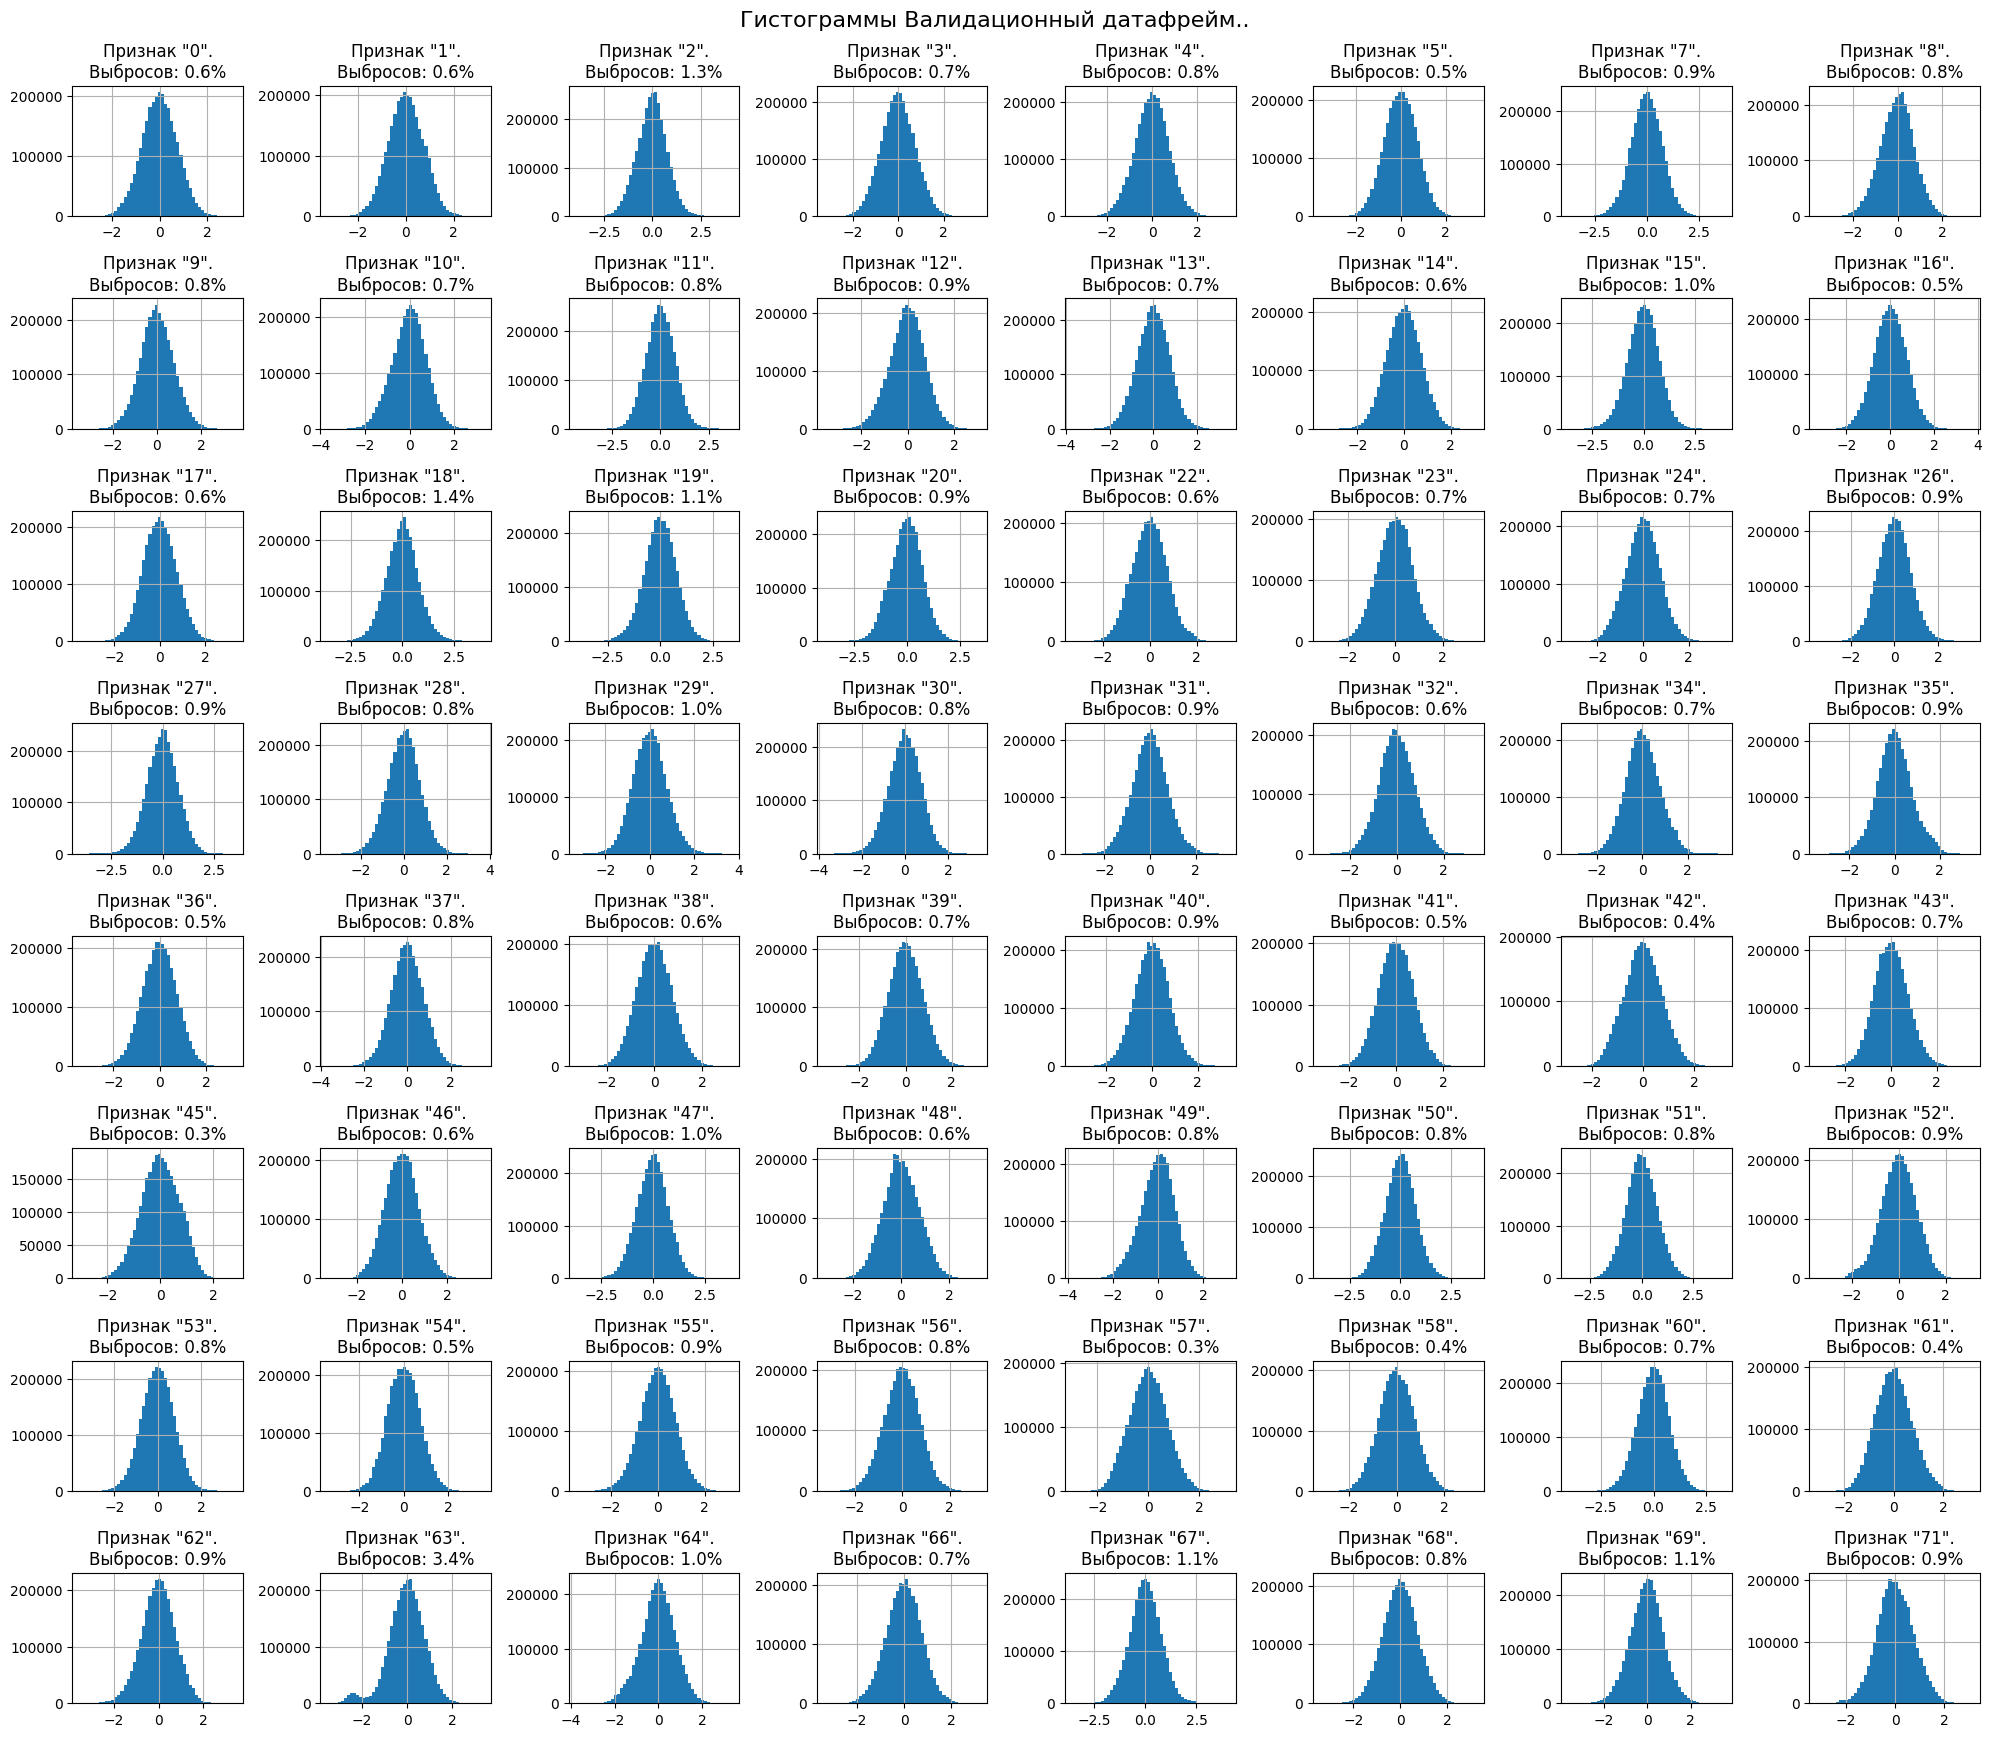

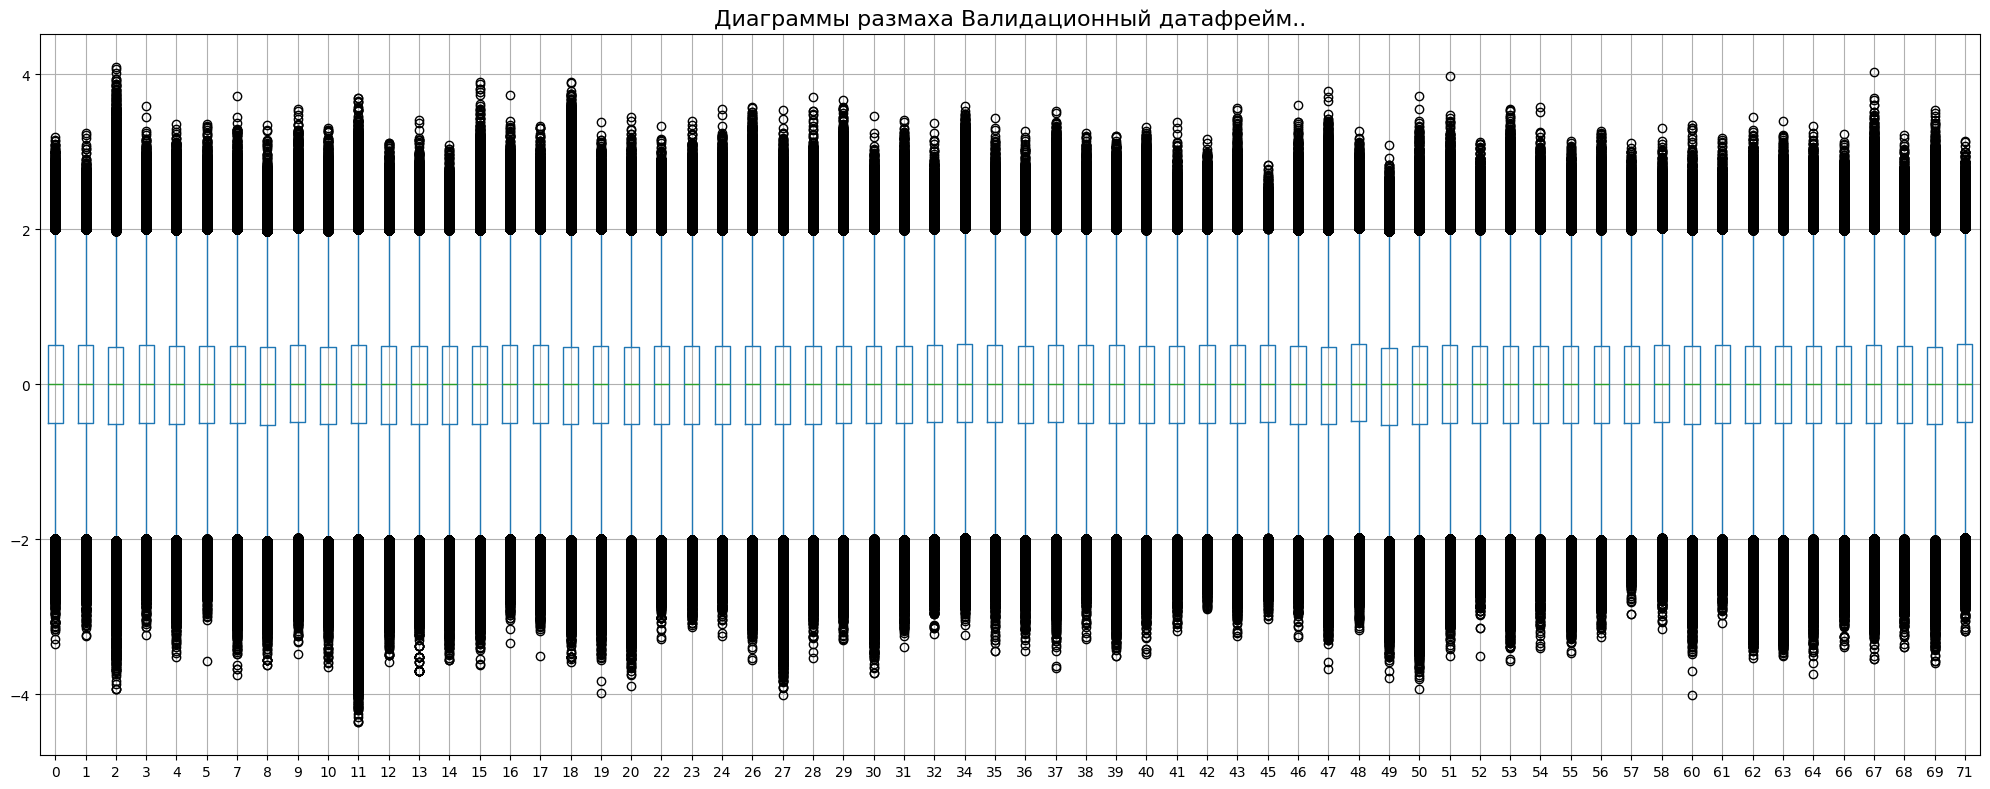

CPU times: total: 1min 21s
Wall time: 1min 19s


In [27]:
%%time
# Удалим признаки, с ненормальным распределеним.
cols = ['6', '21', '25', '33', '44', '59', '65', '70']
df_base_rs = df_base.drop(cols, axis=1)
df_train_rs = df_train.drop(cols, axis=1)
df_val_rs = df_val.drop(cols, axis=1)

# Смасштабируем оставшиеся признаки.
rs = RobustScaler()
df_base_rs = pd.DataFrame(rs.fit_transform(df_base_rs),
                          columns=df_base_rs.columns,
                          index=df_base_rs.index)
df_train_rs = pd.DataFrame(rs.transform(df_train_rs),
                           columns=df_train_rs.columns,
                           index=df_train_rs.index)
df_val_rs = pd.DataFrame(rs.transform(df_val_rs),
                         columns=df_val_rs.columns,
                         index=df_val_rs.index)

# Выведем графики для подвыборки для вcех признаков
# основного датафреймаи и графики для остальных датафреймов.
get_eda_plots(df=df_base_rs,
              name='Основной датафрейм.',
              sample_frac=.1)
get_eda_plots(df=df_train_rs,
              name='Обучающий датафрейм.')
get_eda_plots(df=df_base_rs,
              name='Валидационный датафрейм.')

# Удалим временные переменные.
del [df_base_t, df_train_t]

### Масштабирование и удаление признаков. Вывод.
- Проведено удаление признаков с ненормальным распределением `6`, `21`, `25`, `33`, `44`, `59`, `65`, `70`.
- Проведено масштабирование с использованием `RobustScaler`.

## Вычисление оптимального кол-ва кластеров.

<div style='width: 700px; text-align: justify'>

### Метод "локтя" и коэфф. силуэта.
Найдём оптимальное кол-во кластеров (`n_clusters`) итерацией алгоритма `KMeans`/`MiniBatchKMeans` с инициализацией центроидов `k-means++`
- методом "локтя": вычислением сумм квадратов внутрикластерных расстояний до центроида (параметр `inertia_` в `sklearn`) для каждого `n_clusters` и нахождением точки слома на графике;
- методом вычисления коэффициента силуэта, `silhouette_score`, - меры схожести точки с другими в кластере, по сравнению с другими кластерами, по формуле: $S(i) = \frac{b(i) - a(i)}{max\{a(i), b(i)\}}$ , где
  - $S(i)$ &nbsp;коэффициент силуэта для точки i,
  - $a(i)$ &nbsp;среднее расстояние между точкой i и другими точками её кластера,
  - $b(i)$ &nbsp;среднее расстояние между точкой i и точками ближайшего кластера.

#### Функция построения графиков для коэффициентов метода "локтя" и силуэта.

In [28]:
# Функция построения графиков для коэффициентов метода "локтя"
# и силуэта.
def get_k_plots(df : pd.DataFrame(),
                n_clusters : list,
                sample_size : None,
                seed = SEED):
    '''
    Calculates silhouette and sum of squared distance coefficients
    and plots them for each k.
    Arguments:
    - df: dataframe to evaluate.
    - model: KMeans / MiniBatchKMeans.
    - k_list: list of numbers of clusters to evaluate.
    - sample_size: int. sample size for silhouette coefficient.
    '''
    # Зададим списки для сбора коэфф.
    silhouette_avg = []
    sum_squared_dist = []

    # Вычислим коэффициенты.
    for ni in tqdm(n_clusters):
        # Инициализация KMeans / MiniBatchKMeans.
        if sample_size:
            cluster_k = MiniBatchKMeans(n_clusters=ni,
                                        init='k-means++',
                                        n_init='auto',
                                        batch_size=1536,
                                        random_state=seed)
            cluster_k.fit(df)
            # Запишем коэффициент силуэта.
            silhouette_avg.append(silhouette_score(df,
                                                   cluster_k.labels_,
                                                   sample_size=sample_size,
                                                   random_state=seed))
        else:
            cluster_k = KMeans(n_clusters=ni,
                               init='k-means++',
                               n_init='auto',
                               random_state=SEED)
            cluster_k.fit(df)

            # Запишем коэффициент силуэта.
            silhouette_avg.append(silhouette_score(df,
                                                   cluster_k.labels_,
                                                   random_state=seed))
        # Запишем сумму квадратов расстояний.
        sum_squared_dist.append(cluster_k.inertia_)

    # Выведем графики.
    plt.figure(figsize=(10, 10))
    plt.plot(n_clusters, silhouette_avg, 'x-')
    plt.plot(n_clusters, [el*1e-9 for el in sum_squared_dist], 'o-');
    # plt.axvline(x=50, ls=':')
    plt.legend(['Коэффициент силуэта.',
                'Сумма квадратов расстояний \n(1e-9).',
                'Оптимальное число кластеров.'])
    plt.xlabel('Кол-во кластеров.')
    plt.xticks(n_clusters)
    plt.ylabel('Коэффициенты.')
    plt.title('Поиск оптимального кол-ва кластеров.\n"Метод '+
              'локтя" и "коэфф. силуэта".')
    plt.show();

#### Построение графиков для коэффициентов метода "локтя" и силуэта.
- Вызовем функцию и построим график.

  0%|          | 0/8 [00:00<?, ?it/s]

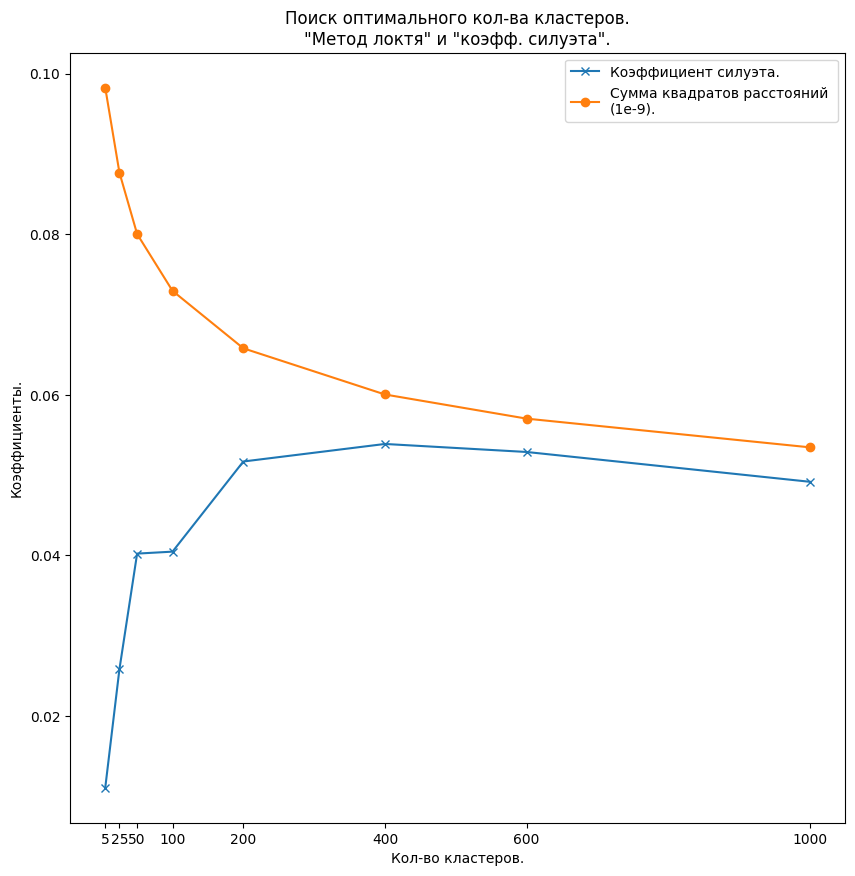

CPU times: total: 7min 56s
Wall time: 2min 6s


In [29]:
%%time
# Вызовем функцию и построим график.
get_k_plots(df_base_rs,
            sample_size = 25000,
            n_clusters=[5, 25, 50, 100, 200, 400, 600, 1000])

<div style='width: 700px; text-align: justify'>

### Вычисление оптимального кол-ва кластеров. Промежуточный вывод.
- Т.к. на кривой значений сумм квадратов расстояний не наблюдается очевидная точка излома, определить оптимальное кол-во кластеров методом "локтя" не представляется возможным.
- Кривая коэффициента силуэта показывает максимум в районе 400 кластеров, но все значения слишком близки к 0, чтобы утверждать, что найдена удовлетворительная разделимость.
- Вычислим дополнительные коэффициенты кластеризации.

<div style='width: 700px; text-align: justify'>

### Коэффициент кластеризации Дэвиса-Болдина.
- Создадим функцию вычисления коэффициента схожести кластеров Дэвиса-Болдина.
- Для экономии времени исполнения кода вычислим коэффициенты для `MiniBatchKMeans`, которые должны приближенно соответствовать коэффициентам для `KMeans`.

#### Функция вычисления коэффициента схожести кластеров Дэвиса-Болдина.

In [30]:
# Вычисление оптимального кол-ва кластеров.
def get_clustering_coeff(df: pd.DataFrame(),
                         n_clusters: list,
                         model = KMeans,
                         seed = SEED):
    '''
    Calculates Davis-Bouldin coefficient for provided dataframe
    and numbers of clusters.
    '''
    if isinstance(n_clusters, int):
        n_clusters = [n_clusters]

    start = perf_counter()
    db_score_list = []

    for ni in tqdm(n_clusters):
        # Инициализация KMeans / MiniBatchKMeans.
        if model == MiniBatchKMeans:
            cluster_k = MiniBatchKMeans(n_clusters=ni,
                                        init='k-means++',
                                        n_init='auto',
                                        batch_size=1536,
                                        random_state=seed).fit(df)
        elif model == KMeans:
            cluster_k = KMeans(n_clusters=ni,
                               init='k-means++',
                               n_init='auto',
                               random_state=seed).fit(df)

        # Разделим df на ni кластеров.
        db_score = davies_bouldin_score(df, cluster_k.labels_)

        # Соберём рез-таты в список.
        db_score_list.append([ni,
                              db_score,
                              perf_counter() - start])
    # Выведем результат.
    db_score_frame = pd.DataFrame(db_score_list,
                                  columns=['Кол-во кластеров:',
                                           'Коэфф. Дэвиса-Болдина:',
                                           'Время оценки:'])
    display(db_score_frame
            .sort_values(by='Коэфф. Дэвиса-Болдина:')
            .style
            .format(precision=3)
            .set_caption('Коэффициент схожести кластеров '+
                         '\nДевиса-Болдина (меньше - лучше, минимум = 0).')
            .set_table_styles(styles))

#### Расчёт коэффициентов схожести кластеров Дэвиса-Болдина.
Вызовем функцию, вычислим и выведем коэффициенты.

In [31]:
%%time
get_clustering_coeff(df=df_base_rs,
                     n_clusters=[50, 100, 500, 1000, 5000, 10000],
                     model=MiniBatchKMeans)
print('\n')

  0%|          | 0/6 [00:00<?, ?it/s]

,Кол-во кластеров:,Коэфф. Дэвиса-Болдина:,Время оценки:
5,10000,2.517,560.849
4,5000,2.621,207.839
3,1000,2.781,56.879
2,500,2.870,29.012
1,100,3.029,12.644
0,50,3.275,5.610




CPU times: total: 31min 53s
Wall time: 9min 20s


<div style='width: 700px; text-align: justify'>
    
### Вычисление оптимального кол-ва кластеров. Вывод.
- Одной из причин улучшения/снижения коэффициента Девиса-Болдина с увеличением кол-ва кластеров, может быть большое оптимальное кол-во.
- Т.к. технической возможности тестировать разделение данных на большие кол-ва кластеров нет, переберём по нескольку оптимальных вариантов для каждого алгоритма.

## `FAISS`. Тесты параметров.

<div style='width: 700px; text-align: justify'>

### `FAISS`. Тест индекса `IVFx,Flat`.

- Переберём ~минимальное, ~среднее и ~максимальное кол-ва кластеров для индекса `IVFx,Flat`, учитывая размер выборки для обучения индекса по упрощённой формуле: &nbsp; $\large\text{кол-во кластеров} = \sqrt{\text{кол-во объектов в выборке для обучения индекса}}$ .
</div>
<br>
<div style='text-align: center'>

<center>

#### Таблица 1. Параметры для тестирования индекса `IVFx,Flat`.
|Метрика/расстояние:|Кол-во класт., <br>рассматриваемых <br>при поиске (`nprobe`):|Количество<br>кластеров:|Размер выборки <br>для обучения индекса:
|:-|:-|:-|:-
|все|$1$, $10$|$100$|$10\%$ от размера базовой выборки
|все|$100$|$1\ 000$|$1\ 000^2 = 1\ 000\ 000$
|все|$200$|$1\ 600$|$1\ 600^2 = 2\ 560\ 000$

</center>
</div>

In [32]:
%%time
# Зададим список для сбора данных.
ivfflat_results_1_list = []

# Соберём данные.
with tqdm(total=16) as pbar:
    for metric, params in itertools.product(
        ['euclidean', 'mahalanobis', 'cosine', 'mips'], # Метрики/расстояния
        zip([1, 10, 100, 200], # Кол-во посещаемых кластеров
            [100, 100, 1000, 1600], # Кол-во кластеров
            [int(df_base.shape[0] * .1), # Размеры выборок для обучения индекса
             int(df_base.shape[0] * .1),
             1000**2, 1600**2])
    ):
        nprobe, n_cluster, index_train_sample_size = params
        # Получим значения целевой метрики acuracy@5.
        acc_faiss, time_faiss = get_accuracy(
            df = df_base_rs,
            df_eval = df_train_rs,
            target = target_train,
            model_type='faiss',
            faiss_n_clust = n_cluster,
            faiss_metric = metric,
            faiss_nprobe = nprobe,
            faiss_train_sample_size = index_train_sample_size
        )
        ivfflat_results_1_list.append([metric, n_cluster, nprobe,
                                       index_train_sample_size,
                                       acc_faiss, time_faiss])
        pbar.update(1)

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: total: 10h 1min 59s
Wall time: 57min 46s


- Выведем результаты.

,Расстояние/Метрика:,Кол-во кластеров:,Кол-во рассматр. кластеров:,Размер выборки:,accuracy@5:,Время поиска (сек.):
10,cosine,1600,200,2560000,70.917,308.620
2,euclidean,1600,200,2560000,70.883,322.830
6,mahalanobis,1600,200,2560000,70.878,327.570
9,cosine,1000,100,1000000,70.864,236.760
1,euclidean,1000,100,1000000,70.789,255.390
5,mahalanobis,1000,100,1000000,70.783,257.960
8,cosine,100,10,291813,70.504,229.050
4,mahalanobis,100,10,291813,70.397,293.220
0,euclidean,100,10,291813,70.389,280.950
14,mips,1600,200,2560000,67.022,337.800


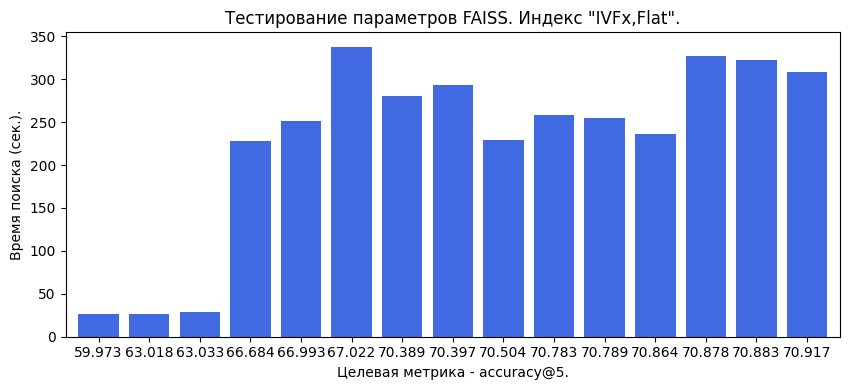

In [34]:
# Создадим и выведем таблицу с результатами.
columns = ['Расстояние/Метрика:', 'Кол-во кластеров:',
           'Кол-во рассматр. кластеров:', 'Размер выборки:',
           'accuracy@5:', 'Время поиска (сек.):']
ivfflat_results_1_list = pd.DataFrame(
    ivfflat_results_1_list[1:],
    columns=columns
)

# cmap = sns.light_palette('green', as_cmap=True)
display(ivfflat_results_1_list
        .sort_values(by='accuracy@5:', ascending=False)
        .style
        .format(precision=3)
        .set_caption('Тестирование параметров FAISS. Индекс "IVFx,Flat".')
        .background_gradient(subset=['accuracy@5:',
                                     'Время поиска (сек.):'],
                             cmap='coolwarm_r')
        .set_table_styles(styles))

results_1_to_plot = ivfflat_results_1_list.sort_values(by='accuracy@5:',
                                                  ascending=True)
results_1_to_plot.plot.bar(figsize=(8.6, 4),
                           x='accuracy@5:',
                           y='Время поиска (сек.):',
                           color='royalblue',
                           legend=False, width=.8)
plt.title('Тестирование параметров FAISS. Индекс "IVFx,Flat".')
plt.xticks(rotation=0)
plt.xlabel('Целевая метрика - accuracy@5.')
plt.ylabel('Время поиска (сек.).')
plt.tight_layout()
plt.show();

<div style='width: 700px; text-align: justify'>

#### `FAISS`. Тест индекса `IVFx,Flat`. Вывод.
- Параметры, дающие наиболее высокий прирост целевой метрики:
  - метрика: косинусное сходство;
  - кол-во рассматриваемых/посещаемых при поиске кластеров `nprobe`: 200;
  - кол-во кластеров: 1600.
- Параметры, дающие достаточно высокий прирост целевой метрики за оптимальное время:
  - метрика: косинусное сходство;
  - кол-во рассматриваемых/посещаемых при поиске кластеров `nprobe`: 100;
  - кол-во кластеров: 1000.

<div style='width: 700px; text-align: justify'>

### `FAISS`. Тест индекса `IVFx_HNSWM,Flat`.
- Учтём рекомендуемое разработчиками соотношение кол-в кластеров и размера выборки для обучения индекса `IVFx_HNSWM,Flat`:
$$
\large\text{кол-во кластеров} = \frac{\text{кол-во объектов в выборке для обучения индекса}} {\text{от }30\text{ до }256}
$$

- Рекомендуемое разработчиками кол-во кластеров (65536) слишком ресурсозатратно. <br>
В связи с этим, используем минимальный делитель - 30, и переберём параметры, указанные в таблице 2.
</div>
<br>
<div style='text-align: center'>
<center>

#### Таблица 2. Параметры для тестирования индекса `IVFx_HNSWM,Flat`.
|Описание:|Кол-во класт., <br>рассматриваемых <br>при поиске (`nprobe`):|Количество<br>кластеров:|Кол-во связей <br>на центроид (`M`):|Глубина поиска (`efSearch`):|Размер выборки <br>для обучения индекса:
|--|:-|:-|:-|:-|:-
|произвольное кол-во кластеров|$10$|$100$|$32, 64, 128$|-|$10\%$ от размера базовой выборки
|кол-во кластеров для минимального<br>размера выборки для обучения индекса|$200$|$\sim9\ 727$|$32, 64, 128$|$50$|$10\%$ от размера базовой выборки
|максимально возможное кол-во <br>кластеров для вычисл.<br> мощностей в наличии|$500$|$16\ 384$|$32, 64, 128$|$100$|$16\ 384*30 = 491\ 520$

</center>
</div>

In [35]:
%%time
# Зададим константы и список для сбора рез-тов.
SAMPLE_COEFF = 30
ABNORMAL_CLUST = 100
MIN_SAMPLE = int(df_base.shape[0] * .1)
MAX_SAMPLE= 16384 * SAMPLE_COEFF
ivfhnsw_results_1_list = []

# Переберём параметры.
with tqdm(total=6) as pbar:
    for faiss_m, params_hnsw in itertools.product(
        # Кол-во связей на центроид M.
        [32, 64],
        zip(
            # Кол-во кластеров.
            [ABNORMAL_CLUST,
             int(MIN_SAMPLE / SAMPLE_COEFF),
             int(MAX_SAMPLE / SAMPLE_COEFF)],
            # Кол-во посещаемых кластеров nprobe.
            [10, 200, 500],
            # Глубина поиска efSearch.
            [None, 50, 100],
            # Размеры выборок для обучения индекса.
            [MIN_SAMPLE, MIN_SAMPLE, MAX_SAMPLE]
        )
    ):
        (n_clust,
         faiss_nprobe,
         faiss_ef_search,
         faiss_train_sample_size) = params_hnsw

        # Получим значения целевой метрики acuracy@5.
        acc_faiss, time_faiss = get_accuracy(
            df = df_base_rs,
            df_eval = df_train_rs,
            target = target_train,
            model_type='faiss',
            faiss_index = 'ivf_hnsw',
            faiss_m = faiss_m,
            faiss_n_clust = n_clust,
            faiss_nprobe=faiss_nprobe,
            faiss_ef_search=faiss_ef_search,
            faiss_train_sample_size = faiss_train_sample_size
        )
        pbar.update(1)

        ivfhnsw_results_1_list.append([faiss_nprobe, faiss_m,
                                       faiss_ef_search, n_clust,
                                       faiss_train_sample_size,
                                       acc_faiss, time_faiss])

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: total: 4h 13min 21s
Wall time: 26min 7s


In [36]:
# Создадим и выведем таблицу с результатами.
columns = ['Кол-во посещаемых кластеров:', 'Глубина поиска',
           'Кол-во связей на центроид', 'Кол-во кластеров:',
           'Размер выборки:', 'accuracy@5:', 'Время поиска (сек.):']
ivfhnsw_results_1 = pd.DataFrame(
    ivfhnsw_results_1_list,
    columns=columns
)

display(ivfhnsw_results_1
        .sort_values(by='accuracy@5:', ascending=False)
        .style
        .format(precision=3)
        .set_caption('Тестирование параметров FAISS. Индекс '+
                     '"IVFx_HNSWM,Flat".')
        .background_gradient(subset=['accuracy@5:',
                                     'Время поиска (сек.):'],
                             cmap='coolwarm_r')
        .set_table_styles(styles))

,Кол-во посещаемых кластеров:,Глубина поиска,Кол-во связей на центроид,Кол-во кластеров:,Размер выборки:,accuracy@5:,Время поиска (сек.):
3,10,64,nan,100,291813,70.389,316.570
0,10,32,nan,100,291813,70.332,303.220
4,200,64,50.000,9727,291813,68.952,158.050
5,500,64,100.000,16384,491520,68.670,309.270
1,200,32,50.000,9727,291813,68.327,156.080
2,500,32,100.000,16384,491520,67.975,316.610


<div style='width: 700px; text-align: justify'>

#### `FAISS`. Тест индекса `IVFx_HNSWM,Flat`. Вывод.
- Индекс показал худшие результаты на большем кол-ве кластеров (16384). Видимо, требуется либо увеличение размера выборки, обучающей индекс, либо более тонкая настройка.
- На аномально малом (100) кол-ве кластеров индекс показал приближенно одинаковые результаты по сравнению с `IVFx,Flat` при гораздо более длительном формировании и поиске.

<div style='width: 700px; text-align: justify'>

### `FAISS`. Тест с `PCA`.
- Проведём тестирование с использованием встроенного метода `PCA` и подобранных параметров для двух индексов, для определения возможности ускорения поиска без значимой потери в целевой метрике.

In [39]:
%%time
# Тест FAISS с PCA.

# Зададим список для сбора данных.
pca_results_1_list = []

# Соберём данные.
for pca_dims in trange(50, 60, 5):
    # Зададим успешные параметры.
    for (index_type,
         faiss_metric,
         faiss_nprobe,
         n_clust,
         faiss_train_sample_size) in zip(
        ['ivf_flat', 'ivf_hnsw'],
        ['cosine', 'euclidean'],
        [200, 10],
        [1600, ABNORMAL_CLUST],
        [1600**2, MIN_SAMPLE]
    ):

        # Получим значения целевой метрики acuracy@5.
        acc_faiss, time_faiss = get_accuracy(
            df = df_base_rs,
            df_eval = df_train_rs,
            target = target_train,
            model_type='faiss',
            faiss_index = index_type,
            faiss_n_clust = n_clust,
            faiss_metric = faiss_metric,
            faiss_nprobe = faiss_nprobe,
            faiss_pca_dims = pca_dims,
            faiss_train_sample_size = faiss_train_sample_size
        )
        pca_results_1_list.append([pca_dims, index_type, faiss_metric,
                                   faiss_nprobe, n_clust,
                                   faiss_train_sample_size,
                                   acc_faiss, time_faiss])

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: total: 2h 55min 8s
Wall time: 15min 53s


In [40]:
# Создадим и выведем таблицу с результатами.
columns = ['Кол-во признаков:', 'Тип индекса:',
           'Метрика:', 'Кол-во рассматриваемых кластеров', 
           'Кол-во кластеров:', 'Размер выборки',
           'accuracy@5:', 'Время поиска (сек.):']
pca_results_1 = pd.DataFrame(pca_results_1_list,
                             columns=columns)

display(pca_results_1
        .sort_values(by='accuracy@5:', ascending=False)
        .style
        .format(precision=3)
        .set_caption('Тестирование параметров FAISS с PCA.')
        .background_gradient(subset=['accuracy@5:', 'Время поиска (сек.):'],
                             cmap='coolwarm_r')
        .set_table_styles(styles))

,Кол-во признаков:,Тип индекса:,Метрика:,Кол-во рассматриваемых кластеров,Кол-во кластеров:,Размер выборки,accuracy@5:,Время поиска (сек.):
2,55,ivf_flat,cosine,200,1600,2560000,70.635,269.870
0,50,ivf_flat,cosine,200,1600,2560000,70.380,250.410
3,55,ivf_hnsw,euclidean,10,100,291813,70.045,221.940
1,50,ivf_hnsw,euclidean,10,100,291813,69.842,203.650


<div style='width: 700px; text-align: justify'>

#### `FAISS`. Тест с `PCA`. Вывод.
- Снижение размерности ожидаемо ускоряет процесс поиска, и несколько повышает `accuracy@5`.

### `FAISS`. Тесты параметров. Вывод.
- Максимальное значение целевой метрики достигнуто с использованием индекса `IVFx,Flat` и параметров:
  - данные смасштабированны с помощью `RobustScaler`;
  - удалены признаки с ненормальным распределением;
  - размерность дополнительно снижена до 55 признаков;
  - метрика: косинусное сходство;
  - кол-во кластеров: 1600;
  - класт., рассматриваемых при поиске (`nprobe`): 200.e)

## `ANNOY`. Тесты параметров.
- Протестируем различные параметры при кол-ве деревьев и узлов для поиска 100 и 200.

In [ ]:
%%time
# Зададим список для сбора данных.
trees_results_1_list = []

# Соберём данные.
for n_trees, annoy_search_n_nodes in product(
    [50, 100, 150, 200, 300, 500],
    [100, 200]
):
# for metric, params_annoy in product(
    # # Расстояния/метрики.
    # ['euclidean', 'angular',
    #  'manhattan', 'hamming', 'dot'],
    # # Кол-во деревьев и узлов для поиска.
    # zip([100, 500],
    #     [100, 200],
    # )
):
    trees, search_n_nodes = params_annoy
    # Получим значения целевой метрики acuracy@5.
    acc_annoy, time_annoy = get_accuracy(
        df = df_base_rs,
        df_eval = df_train_rs,
        target = target_train,
        model_type= 'annoy',
        annoy_n_trees = n_trees,
        annoy_search_n_nodes = search_n_nodes
        # annoy_metric = metric
    )
    trees_results_1_list.append([n_trees, search_n_nodes, metric,
                                 acc_annoy, time_annoy])
    print(trees_results_1_list)

# Создадим и выведем таблицу с результатами.
columns = ['Кол-во деревьев:', 'Кол-во узлов для поиска',
           'accuracy@5:', 'Время поиска (сек.):']
trees_results_1 = pd.DataFrame(trees_results_1_list,
                               columns=columns)
display(trees_results_1
        .sort_values(by='accuracy@5:', ascending=False)
        .style
        .format(precision=3)
        .set_caption('Тестирование ANNOY.')
        .set_table_styles(styles))

  0%|          | 0/14 [00:00<?, ?it/s]

,Кол-во деревьев:,Кол-во узлов для поиска,accuracy@5:,Время поиска (сек.):
13,500,200,67.615,81.140
11,400,200,67.459,48.770
9,300,200,67.375,33.730
7,200,200,67.124,23.320
5,150,200,66.966,19.700
3,100,200,66.591,16.100
12,500,100,65.858,61.140
1,50,200,65.799,11.930
10,400,100,65.658,35.170
8,300,100,65.483,28.070


CPU times: total: 14h 5min
Wall time: 1h 32min 24s


<div style='width: 700px; text-align: justify'>

### `ANNOY`. Тест парметров. Вывод.
- Модель не показала удовлетворительных результатов. Необходима дальнейшая оптимизация параметров.

## Вложенный `KMeans` + `NearestNeighbors`.

In [ ]:
# Функция 3-уровневой кластеризации.
def nested_cluster_nn_search(df : pd.DataFrame, df_eval : pd.DataFrame,
                             n_clusters_1 = 10, n_clusters_2 = 100,
                             nn_sample_size = 100000, k = 5,
                             model = KMeans, seed = SEED, verbose = 1):
    '''
    Returns accuracy@k for given dataframes of vectors by
    - 3-layer clustering;
    - searching for k similar in centroids of both levels and resulting
      clusters using NearestNeighbors:
      1 neighbor for centroids on both levels, k neighbors for resulting
      clusters;
    - comparing indices to targets.

    - Arguments:
      - df: pd.DataFrame. Dataframe of vectors to get matches from.
      - df_eval: pd.DataFrame. Dataframe of vectors for matching.
      - n_clusters_1: int. Number of clusters for the 1st level.
      - n_clusters_2: int. Number of clusters for the 2nd level.
      - nn_sample_size: int. Number of vectors to find matches for.
      - k: int. Number of similar items to search for.
      - model: model class. Accepts KMeans or MiniBatchKMeans.
      - seed: any. Random numbers generator seed;
      - verbose: int. Verbosity. 1 - verbose. 0 - silent.
    '''

    if verbose > 0:
        def verboseprint(*args):
            for arg in args:
                print(arg),
            print
    else:
        verboseprint = lambda *a: None

    # Зададим списки для сбора кластеров и центроид.
    centroids_level_1 = []
    clusters_level_1 = []
    centroids_level_2 = []
    clusters_level_2 = []
    centroids_level_2_all = []

    verboseprint('Начало кластеризации.')
    verboseprint('-' * 10)

    clust_start = perf_counter()

    ## Кластеризация.
    # Создадим экземлпяры класса Kmeans для каждого уровня
    # кластеризации для подходящей модели.
    if model == KMeans:
        model_n1 = model(n_clusters=n_clusters_1,
                         init='k-means++', n_init='auto',
                         random_state=SEED)
        model_n2 = model(n_clusters=n_clusters_2,
                         init='k-means++', n_init='auto',
                         random_state=SEED)
    elif model == MiniBatchKMeans:
        model_n1 = model(n_clusters=n_clusters_1,
                         init='k-means++', n_init='auto',
                         batch_size=1536, random_state=SEED)
        model_n2 = model(n_clusters=n_clusters_2,
                         init='k-means++', n_init='auto',
                         batch_size=1536, random_state=SEED)

    # Получим центроиды первого и второго уровня и кластеры второго уровня.
    # Первый уровень кластеризации.
    clust_n1 = model_n1.fit(df)
    centroids_level_1 = clust_n1.cluster_centers_
    for i in trange(n_clusters_1):
        clusters_level_1.append(df[clust_n1.labels_ == i])
        # Второй уровень кластеризации.
        clust_n2 = model_n2.fit(df[clust_n1.labels_ == i])
        centroids_level_2.append(clust_n2.cluster_centers_)
        for j in range(n_clusters_2):
            centroids_level_2_all.append(clust_n2.cluster_centers_[j])
            clusters_level_2.append(
                df[clust_n1.labels_ == i][clust_n2.labels_ == j]
            )

    # Соберём центроиды первого и второго уровня и центроиды второго
    # и кластеры третьего уровня в группы.
    level_1_2 = []
    level_2_3 = []
    for i in range(n_clusters_1):
        level_1_2.append([centroids_level_1[i], centroids_level_2[i]])
    for i in range(n_clusters_1 * n_clusters_2):
        level_2_3.append([centroids_level_2_all[i], clusters_level_2[i]])

    clust_time = perf_counter() - clust_start

    verboseprint('~' * 70, '\n')
    verboseprint(f'Начало поиска {k} похожих для {nn_sample_size} векторов.')
    verboseprint('-' * 10)

    search_start = perf_counter()

    nn = NearestNeighbors(n_neighbors=1, radius=1.0)
    nn_k = NearestNeighbors(n_neighbors=k, radius=1.0)
    index_nn = []
    df_idxs_level_3 = []

    ## Поиск похожих.
    # Найдём индексы k похожих векторов для среза тестового датафрейма
    # размером nn_train_sample_size.
    for idx in trange(df_eval.iloc[:nn_sample_size].shape[0]):
        # Обучим модель и найдём похожие центроиды первого уровня.
        nn.fit([i[0] for i in level_1_2])
        index_level_1 = nn.kneighbors(
            df_eval.iloc[idx].values.reshape(1,-1),
            return_distance=False
        )

        # Обучим модель и найдём похожие центроиды второго уровня.
        nn.fit(level_1_2[int(index_level_1)][1])
        index_level_2 = nn.kneighbors(
            df_eval.iloc[idx].values.reshape(1,-1),
            return_distance=False
        )
        # Найдем индекс похожего центроида второго уровня для передачи
        final_centroid = level_1_2[int(index_level_1)][1][int(index_level_2)]
        for idx, el in enumerate([i[0] for i in level_2_3]):
            if np.array_equal(el, final_centroid):
                final_centroid_idx = idx

        nn_k.fit([i[1] for i in level_2_3][final_centroid_idx].values)
        index_level_3 = nn_k.kneighbors(
            df_eval.iloc[idx].values.reshape(1,-1),
            return_distance=False
        )

        df_idxs_level_3 = []
        for idxs_level_3 in np.squeeze(index_level_3):
            vector = (
                [i[1] for i in level_2_3][final_centroid_idx]
                .iloc[idxs_level_3]
            )
            df_idxs_level_3.append(
                df.index.get_loc(df.loc[df.eq(vector, 1).all(1)].index[0])
            )

        index_nn.append(df_idxs_level_3)

    base_index = {k: v for k, v in enumerate(df.index.to_list())}

    acc = 0
    for t, el in zip(target_train.values.tolist(), index_nn):
        acc += int(t in [base_index[r] for r in el])

    search_time = perf_counter() - search_start

    verboseprint('\n', '-' * 10, 'Конец работы.')

    # Выведем метрику и время исполнения.
    return round(100 * acc / len(index_nn), 3), clust_time, search_time

Вызовем функцию и выведем результат.

In [ ]:
# Вызовем функцию и выведем результат.
 (acc_custom,
  clust_time,
  search_time) = nested_cluster_nn_search(df_base_rs,
                                          df_train_rs,
                                          n_clusters_1 = 10,
                                          n_clusters_2 = 10,
                                          model=MiniBatchKMeans,
                                          nn_sample_size=10000)

### Вложенный `KMeans` + `NearestNeighbors`. Вывод.
- Добиться сколько-нибудь значимой точности (0.1% на 10000 сэмплов) за отведённое время не удалось.
- Функция требует разделения на уровни кластеризации и общей оптимизации.

# Финальная модель.

In [45]:
%%time
# Получим значения целевой метрики acuracy@5.
acc_faiss, time_faiss = get_accuracy(
    df = df_base_rs,
    df_eval = df_val_rs,
    target = df_val_answer['expected'],
    model_type= 'faiss',
    faiss_index = 'ivf_flat',
    faiss_nprobe = 200,
    faiss_n_clust = 1600,
    faiss_train_sample_size = 1600**2
)

# Создадим и выведем таблицу с результатами.
results = pd.DataFrame([['IVF1600,Flat', 1600, 200,
                         acc_faiss, time_faiss]],
                       columns=['Тип индекса:', 'Кол-во кластеров', 
                                'Кол-во рассм. кластеров:',
                                'accuracy@5:', 'Время поиска (сек.):'])
display(results
        .style
        .format(precision=3)
        .set_caption('Финальная модель.\nВалидационная выборка.')
        .set_table_styles(styles))
print('\n')

,Тип индекса:,Кол-во кластеров,Кол-во рассм. кластеров:,accuracy@5:,Время поиска (сек.):
0,"IVF1600,Flat",1600,200,70.797,333.340




CPU times: total: 56min 49s
Wall time: 5min 34s


<div style='width: 700px; text-align: justify'>

# Общий вывод.
## Результат работы.
  - Максимальное значение целевой метрики `accuracy@5` ~70.8 достигнуто с использованием индекса `IVF1600,Flat` модели `FAISS` и параметров:
    - данные смасштабированны с помощью `RobustScaler`;
    - удалены признаки с ненормальным распределением;
    - размерность дополнительно снижена встроенным методом `PCA` до 55 признаков;
    - метрика: косинусное сходство;
    - кол-во кластеров: 1600;
    - класт., рассматриваемых при поиске (`nprobe`): 200.

## Задача.
  - Был разработан алгоритм, который для всех товаров из `validation.csv` находит 5 похожих из `base.csv`.

## Модели, использовавшиеся в тестах.
- `KMeans` с инициализацией `kmeans++`;
- `MiniBatchKMeans` с инициализацией `kmeans++`;
- `FAISS`;
- `ANNOY`.

## План работы.

- [Загрузка библиотек.](#Загрузка-библиотек.)
- [Установка параметров проекта.](#Установка-параметров-проекта.)
- [Ознакомление с данными, ИАД.](#Ознакомление-с-данными,-ИАД.)
- [Предобработка данных.](#Предобработка-данных.)
- [Кластеризация с поиском `K=5` похожих.](#Кластеризация-с-поиском-K=5-похожих.)
  - [Базовые модели.](#Базовые-модели.)
  - [Масштабирование и удаление признаков.](#Масштабирование-и-удаление-признаков.)
  - [Вычисление оптимального кол-ва кластеров.](#Вычисление-оптимального-кол-ва-кластеров.)
  - [`FAISS`. Тесты параметров.](#FAISS.-Тесты-параметров.)
  - [`ANNOY`. Тесты параметров.](#ANNOY.-Тесты-параметров.)
  - [Вложенный `KMeans` + `NEarestNeighbors`.](#Вложенный-KMeans-+-NearestNeighbors.)
- [Общий вывод.](#Общий-вывод.)

## Данные.
- Размер датасетов:
  - `df_base`: 2918139 X 72 с идентификаторами объектов в индексе;
  - `df_train`: 100000 X 73, в т.ч. признак ответов, и с идентификаторами объектов в индексе;
  - `df_val`: 100000 X 72 с идентификаторами объектов в индексе;
  - `df_val_answers`: 100000 X 1 - признак ответов с идентификаторами объектов в индексе.
- Распределение признаков.
  - Признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение. Остальные признаки имеют распределения, приближенные к нормальному. <br>
  Из-за невозможности идентификации признаков и неэффективности преобразований распределений признаков с точки зрения целевой метрики, признаки с ненормальным распределением были удалены.
- Выбросы / аномалии.
  - Почти во всех признаках среднее близко к медиане и присутствует минимальный процент выбросов. Удаление и замена выбросов средним не оказались эффективными.
- Признаки 33 и 44 дискретны, возможно категориальны, т.к. имеют менее 1% и 2% уникальных значений соответственно. Была проведена тестовая кластеризация по уникальным значениям признака `33`, которая не оказалась эффективной.
- Корреляция признаков / мультиколлинеарность.
  - Корреляция признаков не обнаружена.

## Рекомендации / возможные направления улучшения точности мэтчинга.
  - Проведение более развёрнутого анализа кластеров / признаков, в т.ч., покластерного.
  - Оптимизация реализации связки "простых" алгоритмов `KMeans` + `NearestNeigbors`.
  - Добавление ранжирования с использованием успешного индекса `FAISS` для всех признаков и оценкой кандидатов алгоритмом `CatBoost`.